In [ ]:
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-80GB (UUID: GPU-28d75b98-8147-1338-8965-c746184a8687)


In [ ]:
!pip install pycocoevalcap

In [ ]:
import importlib, types, sys
sys.modules['imp'] = types.SimpleNamespace(reload=importlib.reload)


%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os

GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'CS7643_project-main'
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

import sys
if 'google.colab' in sys.modules:
  print(f'Running in google colab. Our path is `{GOOGLE_DRIVE_PATH}`')
else:
  GOOGLE_DRIVE_PATH = '.'
  print('Running locally.')



import sys
import numpy as np
import math
sys.path.append(GOOGLE_DRIVE_PATH)
print(os.listdir(GOOGLE_DRIVE_PATH))

import os
os.chdir('/content/drive/MyDrive/CS7643_project-main')
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mounted at /content/drive
['ablations_out_10', 'daily_task_tracker.md', 'project_roadmap.md', 'image_caption_training.ipynb', 'data_download.ipynb', 'image_caption_evaluation.ipynb', 'image_caption_generation.ipynb', 'data_preprocessing.ipynb', '.gitignore', '.git', 'analysis', 'configs', 'evaluation', 'data', 'Flicker8k_captions', 'Flickr8k_Data', 'generation', 'image-captioning-model', 'lora-experiments', 'models', 'lora_training_experiments.ipynb', 'lora-experiments-v2', 'image_caption_training (full model).ipynb', 'lora_training_experiments_v2 copy.ipynb', 'ablations_out', 'ablations_out_25']
Running in google colab. Our path is `/content/drive/MyDrive/CS7643_project-main`
['ablations_out_10', 'daily_task_tracker.md', 'project_roadmap.md', 'image_caption_training.ipynb', 'data_download.ipynb', 'image_caption_evaluation.ipynb', 'image_caption_generation.ipynb', 'data_preprocessing.ipynb', '.gitig

# LoRA Ablations for Image Captioning: A Deep Learning Investigation

## Project Overview
This notebook implements and evaluates Low-Rank Adaptation (LoRA) techniques for fine-tuning Vision-Language models on image captioning. A key question is investigated:

"How can large pretrained models be efficiently adapted for downstream tasks while minimizing computational overhead?"

### Key Research Questions:
1. Efficiency vs Performance: How much model capacity is actually needed to adapt for good performance?
2. Module Importance: Which transformer components (cross-attention, self-attention, layer norms) are most critical for vision-language tasks?
3. Baseline Comparison: How does starting from a pretrained captioning model compare to building from scratch?

### Experimental Design:
- Base Models: 
  - Negative Control: Fresh ViT + GPT-2 with random cross-attention
  - Pretrained: nlpconnect/vit-gpt2-image-captioning 
- Training Methods: Dense fine-tuning vs LoRA adaptation
- Ablation Targets: Cross-attention only vs + LayerNorms vs + Self-attention
- Dataset: Flickr8k (8,000 images with 5 captions each)

This systematic approach allows isolation of the contribution of different architectural components and adaptation strategies.

In [ ]:
# =========================
# One-cell training script:
# - Runs ablations on BOTH:
#   (A) Negative control: ViT(IN21K) + GPT2 with *fresh* cross-attn
#   (B) Caption-pretrained: nlpconnect/vit-gpt2-image-captioning
# - Ablations (Dense or LoRA):
#   1) cross_only
#   2) cross_plus_ln
#   3) cross_plus_selfattn
# =========================

import os, json, time, random
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from PIL import Image
from tqdm import tqdm

from transformers import (
    VisionEncoderDecoderModel,
    AutoTokenizer,
    ViTImageProcessor,
    AutoModel,
    AutoModelForCausalLM,
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel


# -------------------------
# Config
# -------------------------
@dataclass
class CFG:
    IMG_DIR: str = r'./Flickr8k_Data/Flicker8k_Dataset_resized'
    CAP_DIR: str = r'./Flicker8k_captions'
    OUT_DIR: str = r'./ablations_out_8_16'

    # model ids
    NEG_VIT: str = "google/vit-base-patch16-224-in21k"
    NEG_GPT2: str = "gpt2"
    PRETRAINED_CAPTIONER: str = "nlpconnect/vit-gpt2-image-captioning"

    # training
    MAX_LEN: int = 48
    BATCH_SIZE: int = 32
    EPOCHS: int = 8
    GRAD_ACCUM: int = 8
    LR_DENSE: float = 5e-6          # dense should generally be tiny
    LR_LORA: float = 1e-4           # LoRA can be much larger
    WEIGHT_DECAY: float = 0.0
    SEED: int = 42

    # LoRA
    LORA_R: int = 4
    LORA_ALPHA: int = 16
    LORA_DROPOUT: float = 0.1

cfg = CFG()
# cfg.IMG_DIR = "/content/Flickr8k_Data/Flicker8k_Dataset_resized"
# cfg.CAP_DIR = "/content/Flicker8k_captions"

os.makedirs(cfg.OUT_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
use_amp = (DEVICE == "cuda")
amp_dtype = torch.bfloat16 if DEVICE == "cuda" else torch.float32

# Speed knobs
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.set_float32_matmul_precision("high")


if DEVICE == "cuda":
    torch.backends.cudnn.benchmark = True


# -------------------------
# Reproducibility
# -------------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# -------------------------
# Load Flickr8k pickles
# -------------------------
def load_pickle(path: str):
    import pickle
    with open(path, "rb") as f:
        return pickle.load(f)

train_data = load_pickle(os.path.join(cfg.CAP_DIR, "train_data.pickle"))
dev_data   = load_pickle(os.path.join(cfg.CAP_DIR, "dev_data.pickle"))

print(f"Loaded train images: {len(train_data)} | dev images: {len(dev_data)}")
print(f"Device: {DEVICE}")


# -------------------------
# Dataset
# -------------------------
class Flickr8kDataset(Dataset):
    def __init__(self, data: Dict[str, List[str]], tokenizer, processor, img_dir: str, max_len: int):
        self.tokenizer = tokenizer
        self.processor = processor
        self.img_dir = img_dir
        self.max_len = max_len
        self.samples: List[Tuple[str, str]] = []
        self._pv_cache = {}
        for fn, caps in data.items():
            for c in caps:
                self.samples.append((fn, c))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fn, caption = self.samples[idx]

        if fn in self._pv_cache:
            pixel_values = self._pv_cache[fn]
        else:
            img = Image.open(os.path.join(self.img_dir, fn)).convert("RGB")
            pixel_values = self.processor(img, return_tensors="pt").pixel_values.squeeze(0)
            self._pv_cache[fn] = pixel_values  # cache on CPU

        caption = caption.strip()
        if self.tokenizer.eos_token is not None and not caption.endswith(self.tokenizer.eos_token):
            caption = caption + self.tokenizer.eos_token

        tok = self.tokenizer(
            caption,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt",
        )
        input_ids = tok.input_ids.squeeze(0)
        attention_mask = tok.attention_mask.squeeze(0)

        return {
            "pixel_values": pixel_values,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "filename": fn,
        }



def build_loaders(tokenizer, processor):
    tr = Flickr8kDataset(train_data, tokenizer, processor, cfg.IMG_DIR, cfg.MAX_LEN)
    dv = Flickr8kDataset(dev_data,   tokenizer, processor, cfg.IMG_DIR, cfg.MAX_LEN)

    nw = min(8, (os.cpu_count() or 4))
    train_loader = DataLoader(
        tr, batch_size=cfg.BATCH_SIZE, shuffle=True,
        num_workers=nw, pin_memory=(DEVICE == "cuda"),
        persistent_workers=(nw > 0), prefetch_factor=2 if nw > 0 else None
    )
    dev_loader = DataLoader(
        dv, batch_size=cfg.BATCH_SIZE, shuffle=False,
        num_workers=nw, pin_memory=(DEVICE == "cuda"),
        persistent_workers=(nw > 0), prefetch_factor=2 if nw > 0 else None
    )
    return train_loader, dev_loader


# -------------------------
# Build models
# -------------------------
def configure_common_tokens(model: VisionEncoderDecoderModel, tokenizer):
    if model.config.eos_token_id is None and tokenizer.eos_token_id is not None:
        model.config.eos_token_id = tokenizer.eos_token_id
    if model.config.pad_token_id is None and tokenizer.pad_token_id is not None:
        model.config.pad_token_id = tokenizer.pad_token_id
    if model.config.decoder_start_token_id is None:
        # GPT2-style: start with EOS if no BOS
        model.config.decoder_start_token_id = model.config.eos_token_id
    return model


def build_caption_pretrained():
    model_id = cfg.PRETRAINED_CAPTIONER
    model = VisionEncoderDecoderModel.from_pretrained(model_id)
    processor = ViTImageProcessor.from_pretrained(model_id)
    tokenizer = AutoTokenizer.from_pretrained(model_id)

    # Make sure pad token exists (some GPT2 tokenizers use EOS as pad)
    if tokenizer.pad_token is None and tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token

    model = configure_common_tokens(model, tokenizer)
    model.to(DEVICE)
    model.config.use_cache = False
    return model, tokenizer, processor


def build_negative_control():
    # Fresh encoder + decoder with fresh cross-attention (not caption-pretrained)
    encoder = AutoModel.from_pretrained(cfg.NEG_VIT)

    try:
        decoder = AutoModelForCausalLM.from_pretrained(cfg.NEG_GPT2, add_cross_attention=True, is_decoder=True)
    except TypeError:
        decoder = AutoModelForCausalLM.from_pretrained(cfg.NEG_GPT2, add_cross_attention=True)

    model = VisionEncoderDecoderModel(encoder=encoder, decoder=decoder)

    processor = ViTImageProcessor.from_pretrained(cfg.NEG_VIT)
    tokenizer = AutoTokenizer.from_pretrained(cfg.NEG_GPT2)

    # GPT2 needs pad token for batching. Standard trick: use EOS as PAD (no vocab resize).
    if tokenizer.pad_token is None and tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token

    # Force token ids on the combined model
    model.config.eos_token_id = tokenizer.eos_token_id
    model.config.pad_token_id = tokenizer.pad_token_id
    model.config.decoder_start_token_id = tokenizer.eos_token_id  # GPT2-style start

    model.to(DEVICE)
    model.config.use_cache = False
    return model, tokenizer, processor


# -------------------------
# Ablation selectors
# -------------------------
def freeze_all(model):
    for p in model.parameters():
        p.requires_grad = False

def _is_decoder(name: str) -> bool:
    return "decoder" in name.lower()

def _is_cross(name: str) -> bool:
    n = name.lower()
    return ("crossattention" in n) or ("encoder_attn" in n) or ("cross_attn" in n) or ("ln_cross_attn" in n)

def _is_self_attn(name: str) -> bool:
    n = name.lower()
    # GPT2 self-attn usually has ".attn." in the block; exclude crossattention
    return ("attn" in n) and ("crossattention" not in n) and ("encoder_attn" not in n) and ("cross_attn" not in n)

def _is_decoder_ln(name: str) -> bool:
    n = name.lower()
    return _is_decoder(n) and (".ln" in n or "layernorm" in n or "ln_" in n)

def _is_lora_param(name: str) -> bool:
    return "lora_" in name.lower()


def set_trainable_dense(model, ablation: str):
    """
    ablation in {"cross_only","cross_plus_ln","cross_plus_selfattn"}
    """
    freeze_all(model)
    for name, p in model.named_parameters():
        n = name.lower()
        if not _is_decoder(n):
            continue

        if ablation == "cross_only":
            if _is_cross(n): p.requires_grad = True

        elif ablation == "cross_plus_ln":
            if _is_cross(n) or _is_decoder_ln(n): p.requires_grad = True

        elif ablation == "cross_plus_selfattn":
            if _is_cross(n) or _is_self_attn(n): p.requires_grad = True

        else:
            raise ValueError(f"Unknown ablation: {ablation}")


def add_lora_to_decoder(model):
    """
    Inject ONE LoRA adapter broadly into decoder projections.
    Then use name-based enablement so we can do cross-only vs cross+... without fragile target_paths.
    """
    lcfg = LoraConfig(
        r=cfg.LORA_R,
        lora_alpha=cfg.LORA_ALPHA,
        lora_dropout=cfg.LORA_DROPOUT,
        bias="none",
        task_type=TaskType.CAUSAL_LM,
        target_modules=["c_attn", "c_proj", "q_attn", "c_fc"],  # self-attn + cross-attn + MLP (where present)
    )
    model.decoder = get_peft_model(model.decoder, lcfg, adapter_name="lora_all")

    # Ensure adapter active
    if hasattr(model.decoder, "set_adapter"):
        model.decoder.set_adapter("lora_all")
    return model


def set_trainable_lora(model, ablation: str):
    """
    Enable LoRA weights based on parameter NAME location:
      - cross_only: only LoRA params inside crossattention modules
      - cross_plus_ln: cross_only + decoder LayerNorm weights
      - cross_plus_selfattn: cross_only + LoRA params in self-attn blocks (not cross)
    """
    freeze_all(model)
    for name, p in model.named_parameters():
        n = name.lower()
        if ablation == "cross_only":
            if _is_lora_param(n) and _is_decoder(n) and _is_cross(n): p.requires_grad = True

        elif ablation == "cross_plus_ln":
            if _is_lora_param(n) and _is_decoder(n) and _is_cross(n): p.requires_grad = True
            if _is_decoder_ln(n): p.requires_grad = True

        elif ablation == "cross_plus_selfattn":
            if _is_lora_param(n) and _is_decoder(n) and (_is_cross(n) or _is_self_attn(n)): p.requires_grad = True

        else:
            raise ValueError(f"Unknown ablation: {ablation}")


# -------------------------
# Training loop (teacher-forcing explicitly)
# -------------------------
def build_optimizer(model, lr: float):
    params = [p for p in model.parameters() if p.requires_grad]
    if not params:
        raise RuntimeError("No trainable params (check your ablation selector).")
    try:
        return AdamW(params, lr=lr, weight_decay=cfg.WEIGHT_DECAY, fused=(DEVICE == "cuda"))
    except TypeError:
        return AdamW(params, lr=lr, weight_decay=cfg.WEIGHT_DECAY)

@torch.no_grad()
def _batch_to_teacher_forcing(batch, tokenizer):
    """
    Build decoder_input_ids / labels aligned correctly.
    input_ids: [B, T]
    We use:
      decoder_input_ids = input_ids[:, :-1]
      labels            = input_ids[:,  1:]
    """
    input_ids = batch["input_ids"].to(DEVICE, non_blocking=True)
    attn_mask = batch["attention_mask"].to(DEVICE, non_blocking=True)
    pixel_values = batch["pixel_values"].to(DEVICE, non_blocking=True)

    decoder_input_ids = input_ids[:, :-1].contiguous()
    decoder_attention_mask = attn_mask[:, :-1].contiguous()

    labels = input_ids[:, 1:].contiguous()
    # ignore PAD positions
    pad_id = tokenizer.pad_token_id
    labels = labels.clone()
    labels[labels == pad_id] = -100

    return pixel_values, decoder_input_ids, decoder_attention_mask, labels


def train_one_run(
    *,
    run_name: str,
    base_kind: str,          # "neg" or "pre"
    method: str,             # "dense" or "lora"
    ablation: str,           # see above
    epochs: int = cfg.EPOCHS,
):
    set_seed(cfg.SEED)

    # Build model/tokenizer/processor
    if base_kind == "pre":
        model, tokenizer, processor = build_caption_pretrained()
    elif base_kind == "neg":
        model, tokenizer, processor = build_negative_control()
    else:
        raise ValueError("base_kind must be 'pre' or 'neg'")

    # LoRA injection if needed
    if method == "lora":
        model = add_lora_to_decoder(model)

    # Set trainable params
    if method == "dense":
        set_trainable_dense(model, ablation)
        lr = cfg.LR_DENSE
    else:
        set_trainable_lora(model, ablation)
        lr = cfg.LR_LORA


    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Print a small trainable summary
    trainable = [(n, p) for n, p in model.named_parameters() if p.requires_grad]
    print(f"\n=== RUN: {run_name} ===")
    print(f"Base: {base_kind} | Method: {method} | Ablation: {ablation}")
    print(f"Trainable params: {sum(p.numel() for _,p in trainable):,} / {sum(p.numel() for p in model.parameters()):,}")
    print("Example trainables:", [n for n,_ in trainable[:8]])

    train_loader, dev_loader = build_loaders(tokenizer, processor)
    optimizer = build_optimizer(model, lr=lr)

    model.train()
    t0 = time.time()

    history = {
        "run_name": run_name,
        "base_kind": base_kind,
        "method": method,
        "ablation": ablation,
        "epochs": epochs,
        "lr": lr,
        "total_params": total_params,
        "trainable_params": trainable_params,
        "train_loss": [],
        "dev_loss": []
    }
    global_step = 0

    for ep in range(1, epochs + 1):
        # ---- train ----
        model.train()
        optimizer.zero_grad(set_to_none=True)
        running = 0.0

        pbar = tqdm(enumerate(train_loader, start=1), total=len(train_loader),
                    desc=f"{run_name} | epoch {ep} (train)", leave=True)

        for i, batch in pbar:
            # teacher forcing aligned labels/masks
            with torch.no_grad():
                pixel_values, decoder_input_ids, decoder_attention_mask, labels = _batch_to_teacher_forcing(batch, tokenizer)

            with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=use_amp):
                out = model(
                    pixel_values=pixel_values,
                    decoder_input_ids=decoder_input_ids,
                    decoder_attention_mask=decoder_attention_mask,
                    labels=labels,
                )
                loss = out.loss

            running += float(loss.item())
            (loss / cfg.GRAD_ACCUM).backward()

            if (i % cfg.GRAD_ACCUM == 0) or (i == len(train_loader)):
                torch.nn.utils.clip_grad_norm_([p for p in model.parameters() if p.requires_grad], 1.0)
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                global_step += 1

            if i == 1 or i % 50 == 0:
                pbar.set_postfix(loss=f"{loss.item():.4f}", avg=f"{running/i:.4f}", step=global_step)

        tr_loss = running / len(train_loader)
        history["train_loss"].append(tr_loss)

        # ---- dev ----
        model.eval()
        dev_running = 0.0
        with torch.no_grad():
            for batch in tqdm(dev_loader, desc=f"{run_name} | epoch {ep} (dev)", leave=False):
                pixel_values, decoder_input_ids, decoder_attention_mask, labels = _batch_to_teacher_forcing(batch, tokenizer)
                with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=use_amp):
                    out = model(
                        pixel_values=pixel_values,
                        decoder_input_ids=decoder_input_ids,
                        decoder_attention_mask=decoder_attention_mask,
                        labels=labels,
                    )
                dev_running += float(out.loss.item())

        dv_loss = dev_running / len(dev_loader)
        history["dev_loss"].append(dv_loss)

        print(f"{run_name} | epoch {ep} train={tr_loss:.4f} dev={dv_loss:.4f}")

    history["train_time_sec"] = time.time() - t0

    save_dir = os.path.join(cfg.OUT_DIR, run_name.replace(":", "_").replace("/", "_"))
    os.makedirs(save_dir, exist_ok=True)
    tokenizer.save_pretrained(save_dir)

    if method == "lora" and base_kind == "pre":
        # Save adapter + info (easy reload later)
        os.makedirs(os.path.join(save_dir, "decoder_lora"), exist_ok=True)
        model.decoder.save_pretrained(os.path.join(save_dir, "decoder_lora"))
        with open(os.path.join(save_dir, "lora_model_info.json"), "w") as f:
            json.dump({"base_model_path": cfg.PRETRAINED_CAPTIONER, "has_decoder_lora": True}, f, indent=2)
    else:
        # Save full model (works for negative-control builds too)
        # If LoRA, we merge so it's a standard HF checkpoint.
        if method == "lora" and isinstance(model.decoder, PeftModel):
            model.decoder = model.decoder.merge_and_unload()
        model.save_pretrained(save_dir)

    with open(os.path.join(save_dir, "train_history.json"), "w") as f:
        json.dump(history, f, indent=2)

    print(f"Saved checkpoint: {save_dir}")
    return history


# =========================
# Choose what to run
# =========================
ABLATIONS = ["cross_only", "cross_plus_ln", "cross_plus_selfattn"]

RUNS = []
for base_kind in ["neg", "pre"]:           # negative-control + pretrained captioner
    for method in ["lora", "dense"]:       # recommend LoRA for clean ablations;
        for ab in ABLATIONS:
            RUNS.append((base_kind, method, ab))

RUNS.append(("pre", "dense", "cross_only"))

all_histories = {}
for base_kind, method, ablation in RUNS:
    run_name = f"{base_kind}_{method}_{ablation}_r{cfg.LORA_R}_e{cfg.EPOCHS}"
    hist = train_one_run(run_name=run_name, base_kind=base_kind, method=method, ablation=ablation, epochs=cfg.EPOCHS)
    all_histories[run_name] = hist

# Save master summary
with open(os.path.join(cfg.OUT_DIR, "ALL_RUNS_SUMMARY.json"), "w") as f:
    json.dump(all_histories, f, indent=2)

print("\nDone. Runs saved under:", cfg.OUT_DIR)


Loaded train images: 6000 | dev images: 1000
Device: cuda


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.10.crossattention.c_attn.bias', 'transformer.h.10.crossattention.c_attn.weight', 'transformer.h.10.crossattention.c_proj.bias', 'transformer.h.10.cros


=== RUN: neg_lora_cross_only_r16_e8 ===
Base: neg | Method: lora | Ablation: cross_only
Trainable params: 1,032,192 / 242,587,392
Example trainables: ['decoder.base_model.model.transformer.h.0.crossattention.c_attn.lora_A.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.c_attn.lora_B.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.q_attn.lora_A.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.q_attn.lora_B.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.c_proj.lora_A.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.c_proj.lora_B.lora_all.weight', 'decoder.base_model.model.transformer.h.1.crossattention.c_attn.lora_A.lora_all.weight', 'decoder.base_model.model.transformer.h.1.crossattention.c_attn.lora_B.lora_all.weight']


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
neg_lora_cross_only_r16_e8 | epoch 1 (train): 100%|██████████| 938/938 [02:00<00:00,  7.81it/s, avg=6.9388, loss=5.5070, step=112]


neg_lora_cross_only_r16_e8 | epoch 1 train=6.8855 dev=5.5287


neg_lora_cross_only_r16_e8 | epoch 2 (train): 100%|██████████| 938/938 [01:52<00:00,  8.31it/s, avg=5.3930, loss=5.2815, step=230]


neg_lora_cross_only_r16_e8 | epoch 2 train=5.3856 dev=5.1508


neg_lora_cross_only_r16_e8 | epoch 3 (train): 100%|██████████| 938/938 [01:52<00:00,  8.37it/s, avg=5.1353, loss=4.9465, step=348]


neg_lora_cross_only_r16_e8 | epoch 3 train=5.1307 dev=4.9335


neg_lora_cross_only_r16_e8 | epoch 4 (train): 100%|██████████| 938/938 [01:50<00:00,  8.47it/s, avg=4.9628, loss=4.8288, step=466]


neg_lora_cross_only_r16_e8 | epoch 4 train=4.9601 dev=4.7783


neg_lora_cross_only_r16_e8 | epoch 5 (train): 100%|██████████| 938/938 [01:50<00:00,  8.46it/s, avg=4.8555, loss=4.7700, step=584]


neg_lora_cross_only_r16_e8 | epoch 5 train=4.8561 dev=4.7068


neg_lora_cross_only_r16_e8 | epoch 6 (train): 100%|██████████| 938/938 [01:50<00:00,  8.48it/s, avg=4.8003, loss=4.7556, step=702]


neg_lora_cross_only_r16_e8 | epoch 6 train=4.7988 dev=4.6706


neg_lora_cross_only_r16_e8 | epoch 7 (train): 100%|██████████| 938/938 [01:49<00:00,  8.59it/s, avg=4.7602, loss=4.7908, step=820]


neg_lora_cross_only_r16_e8 | epoch 7 train=4.7615 dev=4.6415


neg_lora_cross_only_r16_e8 | epoch 8 (train): 100%|██████████| 938/938 [01:50<00:00,  8.52it/s, avg=4.7319, loss=4.9670, step=938]


neg_lora_cross_only_r16_e8 | epoch 8 train=4.7313 dev=4.6129
Saved checkpoint: ./ablations_out_8_16/neg_lora_cross_only_r16_e8


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.10.crossattention.c_attn.bias', 'transformer.h.10.crossattention.c_attn.weight', 'transformer.h.10.crossattention.c_proj.bias', 'transformer.h.10.cros


=== RUN: neg_lora_cross_plus_ln_r16_e8 ===
Base: neg | Method: lora | Ablation: cross_plus_ln
Trainable params: 1,089,024 / 242,587,392
Example trainables: ['decoder.base_model.model.transformer.h.0.ln_1.weight', 'decoder.base_model.model.transformer.h.0.ln_1.bias', 'decoder.base_model.model.transformer.h.0.ln_2.weight', 'decoder.base_model.model.transformer.h.0.ln_2.bias', 'decoder.base_model.model.transformer.h.0.crossattention.c_attn.lora_A.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.c_attn.lora_B.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.q_attn.lora_A.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.q_attn.lora_B.lora_all.weight']


neg_lora_cross_plus_ln_r16_e8 | epoch 1 (train): 100%|██████████| 938/938 [02:06<00:00,  7.41it/s, avg=6.3995, loss=5.2826, step=112]


neg_lora_cross_plus_ln_r16_e8 | epoch 1 train=6.3580 dev=5.2734


neg_lora_cross_plus_ln_r16_e8 | epoch 2 (train): 100%|██████████| 938/938 [01:57<00:00,  7.96it/s, avg=5.1632, loss=5.0922, step=230]


neg_lora_cross_plus_ln_r16_e8 | epoch 2 train=5.1558 dev=4.9196


neg_lora_cross_plus_ln_r16_e8 | epoch 3 (train): 100%|██████████| 938/938 [01:55<00:00,  8.14it/s, avg=4.9227, loss=4.7725, step=348]


neg_lora_cross_plus_ln_r16_e8 | epoch 3 train=4.9190 dev=4.7448


neg_lora_cross_plus_ln_r16_e8 | epoch 4 (train): 100%|██████████| 938/938 [01:54<00:00,  8.20it/s, avg=4.8012, loss=4.6757, step=466]


neg_lora_cross_plus_ln_r16_e8 | epoch 4 train=4.7994 dev=4.6549


neg_lora_cross_plus_ln_r16_e8 | epoch 5 (train): 100%|██████████| 938/938 [01:53<00:00,  8.23it/s, avg=4.7231, loss=4.6631, step=584]


neg_lora_cross_plus_ln_r16_e8 | epoch 5 train=4.7238 dev=4.5966


neg_lora_cross_plus_ln_r16_e8 | epoch 6 (train): 100%|██████████| 938/938 [01:52<00:00,  8.32it/s, avg=4.6711, loss=4.6447, step=702]


neg_lora_cross_plus_ln_r16_e8 | epoch 6 train=4.6697 dev=4.5605


neg_lora_cross_plus_ln_r16_e8 | epoch 7 (train): 100%|██████████| 938/938 [01:52<00:00,  8.33it/s, avg=4.6265, loss=4.6891, step=820]


neg_lora_cross_plus_ln_r16_e8 | epoch 7 train=4.6278 dev=4.5201


neg_lora_cross_plus_ln_r16_e8 | epoch 8 (train): 100%|██████████| 938/938 [01:52<00:00,  8.30it/s, avg=4.5908, loss=4.8105, step=938]


neg_lora_cross_plus_ln_r16_e8 | epoch 8 train=4.5902 dev=4.4897
Saved checkpoint: ./ablations_out_8_16/neg_lora_cross_plus_ln_r16_e8


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.10.crossattention.c_attn.bias', 'transformer.h.10.crossattention.c_attn.weight', 'transformer.h.10.crossattention.c_proj.bias', 'transformer.h.10.cros


=== RUN: neg_lora_cross_plus_selfattn_r16_e8 ===
Base: neg | Method: lora | Ablation: cross_plus_selfattn
Trainable params: 1,916,928 / 242,587,392
Example trainables: ['decoder.base_model.model.transformer.h.0.attn.c_attn.lora_A.lora_all.weight', 'decoder.base_model.model.transformer.h.0.attn.c_attn.lora_B.lora_all.weight', 'decoder.base_model.model.transformer.h.0.attn.c_proj.lora_A.lora_all.weight', 'decoder.base_model.model.transformer.h.0.attn.c_proj.lora_B.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.c_attn.lora_A.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.c_attn.lora_B.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.q_attn.lora_A.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.q_attn.lora_B.lora_all.weight']


neg_lora_cross_plus_selfattn_r16_e8 | epoch 1 (train): 100%|██████████| 938/938 [02:06<00:00,  7.40it/s, avg=6.2032, loss=5.2006, step=112]


neg_lora_cross_plus_selfattn_r16_e8 | epoch 1 train=6.1656 dev=5.1590


neg_lora_cross_plus_selfattn_r16_e8 | epoch 2 (train): 100%|██████████| 938/938 [01:59<00:00,  7.84it/s, avg=5.0322, loss=4.9530, step=230]


neg_lora_cross_plus_selfattn_r16_e8 | epoch 2 train=5.0239 dev=4.7485


neg_lora_cross_plus_selfattn_r16_e8 | epoch 3 (train): 100%|██████████| 938/938 [01:57<00:00,  7.99it/s, avg=4.7610, loss=4.6114, step=348]


neg_lora_cross_plus_selfattn_r16_e8 | epoch 3 train=4.7569 dev=4.5780


neg_lora_cross_plus_selfattn_r16_e8 | epoch 4 (train): 100%|██████████| 938/938 [01:56<00:00,  8.08it/s, avg=4.6212, loss=4.5090, step=466]


neg_lora_cross_plus_selfattn_r16_e8 | epoch 4 train=4.6190 dev=4.4700


neg_lora_cross_plus_selfattn_r16_e8 | epoch 5 (train): 100%|██████████| 938/938 [01:56<00:00,  8.08it/s, avg=4.5280, loss=4.4254, step=584]


neg_lora_cross_plus_selfattn_r16_e8 | epoch 5 train=4.5283 dev=4.3997


neg_lora_cross_plus_selfattn_r16_e8 | epoch 6 (train): 100%|██████████| 938/938 [01:55<00:00,  8.15it/s, avg=4.4624, loss=4.3896, step=702]


neg_lora_cross_plus_selfattn_r16_e8 | epoch 6 train=4.4610 dev=4.3500


neg_lora_cross_plus_selfattn_r16_e8 | epoch 7 (train): 100%|██████████| 938/938 [01:54<00:00,  8.16it/s, avg=4.4075, loss=4.4820, step=820]


neg_lora_cross_plus_selfattn_r16_e8 | epoch 7 train=4.4086 dev=4.3078


neg_lora_cross_plus_selfattn_r16_e8 | epoch 8 (train): 100%|██████████| 938/938 [01:55<00:00,  8.14it/s, avg=4.3631, loss=4.5652, step=938]


neg_lora_cross_plus_selfattn_r16_e8 | epoch 8 train=4.3630 dev=4.2753
Saved checkpoint: ./ablations_out_8_16/neg_lora_cross_plus_selfattn_r16_e8


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.10.crossattention.c_attn.bias', 'transformer.h.10.crossattention.c_attn.weight', 'transformer.h.10.crossattention.c_proj.bias', 'transformer.h.10.cros


=== RUN: neg_dense_cross_only_r16_e8 ===
Base: neg | Method: dense | Ablation: cross_only
Trainable params: 28,366,848 / 239,195,904
Example trainables: ['decoder.transformer.h.0.crossattention.c_attn.weight', 'decoder.transformer.h.0.crossattention.c_attn.bias', 'decoder.transformer.h.0.crossattention.q_attn.weight', 'decoder.transformer.h.0.crossattention.q_attn.bias', 'decoder.transformer.h.0.crossattention.c_proj.weight', 'decoder.transformer.h.0.crossattention.c_proj.bias', 'decoder.transformer.h.0.ln_cross_attn.weight', 'decoder.transformer.h.0.ln_cross_attn.bias']


neg_dense_cross_only_r16_e8 | epoch 1 (train): 100%|██████████| 938/938 [01:20<00:00, 11.66it/s, avg=8.4956, loss=8.3512, step=112]


neg_dense_cross_only_r16_e8 | epoch 1 train=8.4897 dev=8.6776


neg_dense_cross_only_r16_e8 | epoch 2 (train): 100%|██████████| 938/938 [01:13<00:00, 12.79it/s, avg=7.9223, loss=7.3465, step=230]


neg_dense_cross_only_r16_e8 | epoch 2 train=7.9034 dev=7.8135


neg_dense_cross_only_r16_e8 | epoch 3 (train): 100%|██████████| 938/938 [01:11<00:00, 13.11it/s, avg=7.1248, loss=6.6876, step=348]


neg_dense_cross_only_r16_e8 | epoch 3 train=7.1137 dev=6.9646


neg_dense_cross_only_r16_e8 | epoch 4 (train): 100%|██████████| 938/938 [01:09<00:00, 13.51it/s, avg=6.5477, loss=6.1164, step=466]


neg_dense_cross_only_r16_e8 | epoch 4 train=6.5393 dev=6.4171


neg_dense_cross_only_r16_e8 | epoch 5 (train): 100%|██████████| 938/938 [01:09<00:00, 13.50it/s, avg=6.1493, loss=5.9621, step=584]


neg_dense_cross_only_r16_e8 | epoch 5 train=6.1413 dev=6.0585


neg_dense_cross_only_r16_e8 | epoch 6 (train): 100%|██████████| 938/938 [01:08<00:00, 13.62it/s, avg=5.9088, loss=5.9040, step=702]


neg_dense_cross_only_r16_e8 | epoch 6 train=5.9053 dev=5.8429


neg_dense_cross_only_r16_e8 | epoch 7 (train): 100%|██████████| 938/938 [01:08<00:00, 13.65it/s, avg=5.7523, loss=5.7586, step=820]


neg_dense_cross_only_r16_e8 | epoch 7 train=5.7513 dev=5.6977


neg_dense_cross_only_r16_e8 | epoch 8 (train): 100%|██████████| 938/938 [01:09<00:00, 13.57it/s, avg=5.6437, loss=5.5916, step=938]


neg_dense_cross_only_r16_e8 | epoch 8 train=5.6401 dev=5.5914
Saved checkpoint: ./ablations_out_8_16/neg_dense_cross_only_r16_e8


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.10.crossattention.c_attn.bias', 'transformer.h.10.crossattention.c_attn.weight', 'transformer.h.10.crossattention.c_proj.bias', 'transformer.h.10.cros


=== RUN: neg_dense_cross_plus_ln_r16_e8 ===
Base: neg | Method: dense | Ablation: cross_plus_ln
Trainable params: 28,405,248 / 239,195,904
Example trainables: ['decoder.transformer.h.0.ln_1.weight', 'decoder.transformer.h.0.ln_1.bias', 'decoder.transformer.h.0.ln_2.weight', 'decoder.transformer.h.0.ln_2.bias', 'decoder.transformer.h.0.crossattention.c_attn.weight', 'decoder.transformer.h.0.crossattention.c_attn.bias', 'decoder.transformer.h.0.crossattention.q_attn.weight', 'decoder.transformer.h.0.crossattention.q_attn.bias']


neg_dense_cross_plus_ln_r16_e8 | epoch 1 (train): 100%|██████████| 938/938 [01:21<00:00, 11.53it/s, avg=8.3470, loss=8.0371, step=112]


neg_dense_cross_plus_ln_r16_e8 | epoch 1 train=8.3347 dev=8.3984


neg_dense_cross_plus_ln_r16_e8 | epoch 2 (train): 100%|██████████| 938/938 [01:15<00:00, 12.47it/s, avg=7.5083, loss=6.9531, step=230]


neg_dense_cross_plus_ln_r16_e8 | epoch 2 train=7.4873 dev=7.2497


neg_dense_cross_plus_ln_r16_e8 | epoch 3 (train): 100%|██████████| 938/938 [01:12<00:00, 12.90it/s, avg=6.5660, loss=6.1245, step=348]


neg_dense_cross_plus_ln_r16_e8 | epoch 3 train=6.5516 dev=6.2582


neg_dense_cross_plus_ln_r16_e8 | epoch 4 (train): 100%|██████████| 938/938 [01:11<00:00, 13.12it/s, avg=5.9250, loss=5.5691, step=466]


neg_dense_cross_plus_ln_r16_e8 | epoch 4 train=5.9195 dev=5.7438


neg_dense_cross_plus_ln_r16_e8 | epoch 5 (train): 100%|██████████| 938/938 [01:11<00:00, 13.06it/s, avg=5.6422, loss=5.5191, step=584]


neg_dense_cross_plus_ln_r16_e8 | epoch 5 train=5.6359 dev=5.5293


neg_dense_cross_plus_ln_r16_e8 | epoch 6 (train): 100%|██████████| 938/938 [01:11<00:00, 13.21it/s, avg=5.4877, loss=5.5907, step=702]


neg_dense_cross_plus_ln_r16_e8 | epoch 6 train=5.4857 dev=5.4090


neg_dense_cross_plus_ln_r16_e8 | epoch 7 (train): 100%|██████████| 938/938 [01:10<00:00, 13.30it/s, avg=5.3863, loss=5.4030, step=820]


neg_dense_cross_plus_ln_r16_e8 | epoch 7 train=5.3863 dev=5.3200


neg_dense_cross_plus_ln_r16_e8 | epoch 8 (train): 100%|██████████| 938/938 [01:10<00:00, 13.37it/s, avg=5.3152, loss=5.2677, step=938]


neg_dense_cross_plus_ln_r16_e8 | epoch 8 train=5.3120 dev=5.2494
Saved checkpoint: ./ablations_out_8_16/neg_dense_cross_plus_ln_r16_e8


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.10.crossattention.c_attn.bias', 'transformer.h.10.crossattention.c_attn.weight', 'transformer.h.10.crossattention.c_proj.bias', 'transformer.h.10.cros


=== RUN: neg_dense_cross_plus_selfattn_r16_e8 ===
Base: neg | Method: dense | Ablation: cross_plus_selfattn
Trainable params: 56,715,264 / 239,195,904
Example trainables: ['decoder.transformer.h.0.attn.c_attn.weight', 'decoder.transformer.h.0.attn.c_attn.bias', 'decoder.transformer.h.0.attn.c_proj.weight', 'decoder.transformer.h.0.attn.c_proj.bias', 'decoder.transformer.h.0.crossattention.c_attn.weight', 'decoder.transformer.h.0.crossattention.c_attn.bias', 'decoder.transformer.h.0.crossattention.q_attn.weight', 'decoder.transformer.h.0.crossattention.q_attn.bias']


neg_dense_cross_plus_selfattn_r16_e8 | epoch 1 (train): 100%|██████████| 938/938 [01:24<00:00, 11.11it/s, avg=7.4314, loss=6.3027, step=112]


neg_dense_cross_plus_selfattn_r16_e8 | epoch 1 train=7.3906 dev=6.3852


neg_dense_cross_plus_selfattn_r16_e8 | epoch 2 (train): 100%|██████████| 938/938 [01:17<00:00, 12.03it/s, avg=5.8581, loss=5.5373, step=230]


neg_dense_cross_plus_selfattn_r16_e8 | epoch 2 train=5.8437 dev=5.4840


neg_dense_cross_plus_selfattn_r16_e8 | epoch 3 (train): 100%|██████████| 938/938 [01:14<00:00, 12.54it/s, avg=5.4068, loss=5.3571, step=348]


neg_dense_cross_plus_selfattn_r16_e8 | epoch 3 train=5.4042 dev=5.2455


neg_dense_cross_plus_selfattn_r16_e8 | epoch 4 (train): 100%|██████████| 938/938 [01:13<00:00, 12.82it/s, avg=5.2166, loss=4.8660, step=466]


neg_dense_cross_plus_selfattn_r16_e8 | epoch 4 train=5.2154 dev=5.0911


neg_dense_cross_plus_selfattn_r16_e8 | epoch 5 (train): 100%|██████████| 938/938 [01:13<00:00, 12.71it/s, avg=5.0920, loss=4.9907, step=584]


neg_dense_cross_plus_selfattn_r16_e8 | epoch 5 train=5.0870 dev=4.9810


neg_dense_cross_plus_selfattn_r16_e8 | epoch 6 (train): 100%|██████████| 938/938 [01:13<00:00, 12.84it/s, avg=4.9889, loss=5.1510, step=702]


neg_dense_cross_plus_selfattn_r16_e8 | epoch 6 train=4.9878 dev=4.9032


neg_dense_cross_plus_selfattn_r16_e8 | epoch 7 (train): 100%|██████████| 938/938 [01:13<00:00, 12.83it/s, avg=4.9060, loss=4.9313, step=820]


neg_dense_cross_plus_selfattn_r16_e8 | epoch 7 train=4.9066 dev=4.8322


neg_dense_cross_plus_selfattn_r16_e8 | epoch 8 (train): 100%|██████████| 938/938 [01:12<00:00, 12.89it/s, avg=4.8490, loss=4.8771, step=938]


neg_dense_cross_plus_selfattn_r16_e8 | epoch 8 train=4.8454 dev=4.7780
Saved checkpoint: ./ablations_out_8_16/neg_dense_cross_plus_selfattn_r16_e8

=== RUN: pre_lora_cross_only_r16_e8 ===
Base: pre | Method: lora | Ablation: cross_only
Trainable params: 1,032,192 / 242,587,392
Example trainables: ['decoder.base_model.model.transformer.h.0.crossattention.c_attn.lora_A.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.c_attn.lora_B.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.q_attn.lora_A.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.q_attn.lora_B.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.c_proj.lora_A.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.c_proj.lora_B.lora_all.weight', 'decoder.base_model.model.transformer.h.1.crossattention.c_attn.lora_A.lora_all.weight', 'decoder.base_model.model.transformer.h.1.crossattention.c_attn.lora_B.lora_al

pre_lora_cross_only_r16_e8 | epoch 1 (train): 100%|██████████| 938/938 [02:00<00:00,  7.76it/s, avg=6.9692, loss=5.4471, step=112]


pre_lora_cross_only_r16_e8 | epoch 1 train=6.8978 dev=5.1006


pre_lora_cross_only_r16_e8 | epoch 2 (train): 100%|██████████| 938/938 [01:54<00:00,  8.21it/s, avg=4.9216, loss=5.0234, step=230]


pre_lora_cross_only_r16_e8 | epoch 2 train=4.9166 dev=4.6443


pre_lora_cross_only_r16_e8 | epoch 3 (train): 100%|██████████| 938/938 [01:52<00:00,  8.31it/s, avg=4.6537, loss=4.4422, step=348]


pre_lora_cross_only_r16_e8 | epoch 3 train=4.6502 dev=4.4533


pre_lora_cross_only_r16_e8 | epoch 4 (train): 100%|██████████| 938/938 [01:52<00:00,  8.35it/s, avg=4.5100, loss=4.9944, step=466]


pre_lora_cross_only_r16_e8 | epoch 4 train=4.5108 dev=4.3427


pre_lora_cross_only_r16_e8 | epoch 5 (train): 100%|██████████| 938/938 [01:51<00:00,  8.43it/s, avg=4.4216, loss=4.6049, step=584]


pre_lora_cross_only_r16_e8 | epoch 5 train=4.4204 dev=4.2693


pre_lora_cross_only_r16_e8 | epoch 6 (train): 100%|██████████| 938/938 [01:50<00:00,  8.48it/s, avg=4.3571, loss=4.2288, step=702]


pre_lora_cross_only_r16_e8 | epoch 6 train=4.3549 dev=4.2188


pre_lora_cross_only_r16_e8 | epoch 7 (train): 100%|██████████| 938/938 [01:50<00:00,  8.47it/s, avg=4.3064, loss=4.4316, step=820]


pre_lora_cross_only_r16_e8 | epoch 7 train=4.3054 dev=4.1766


pre_lora_cross_only_r16_e8 | epoch 8 (train): 100%|██████████| 938/938 [01:50<00:00,  8.49it/s, avg=4.2636, loss=4.1898, step=938]
/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:295: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


pre_lora_cross_only_r16_e8 | epoch 8 train=4.2634 dev=4.1393
Saved checkpoint: ./ablations_out_8_16/pre_lora_cross_only_r16_e8

=== RUN: pre_lora_cross_plus_ln_r16_e8 ===
Base: pre | Method: lora | Ablation: cross_plus_ln
Trainable params: 1,089,024 / 242,587,392
Example trainables: ['decoder.base_model.model.transformer.h.0.ln_1.weight', 'decoder.base_model.model.transformer.h.0.ln_1.bias', 'decoder.base_model.model.transformer.h.0.ln_2.weight', 'decoder.base_model.model.transformer.h.0.ln_2.bias', 'decoder.base_model.model.transformer.h.0.crossattention.c_attn.lora_A.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.c_attn.lora_B.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.q_attn.lora_A.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.q_attn.lora_B.lora_all.weight']


pre_lora_cross_plus_ln_r16_e8 | epoch 1 (train): 100%|██████████| 938/938 [02:02<00:00,  7.64it/s, avg=6.1952, loss=5.1218, step=112]


pre_lora_cross_plus_ln_r16_e8 | epoch 1 train=6.1405 dev=4.7203


pre_lora_cross_plus_ln_r16_e8 | epoch 2 (train): 100%|██████████| 938/938 [01:56<00:00,  8.08it/s, avg=4.6413, loss=4.7892, step=230]


pre_lora_cross_plus_ln_r16_e8 | epoch 2 train=4.6386 dev=4.4168


pre_lora_cross_plus_ln_r16_e8 | epoch 3 (train): 100%|██████████| 938/938 [01:54<00:00,  8.16it/s, avg=4.4551, loss=4.3503, step=348]


pre_lora_cross_plus_ln_r16_e8 | epoch 3 train=4.4529 dev=4.2885


pre_lora_cross_plus_ln_r16_e8 | epoch 4 (train): 100%|██████████| 938/938 [01:53<00:00,  8.28it/s, avg=4.3492, loss=4.8002, step=466]


pre_lora_cross_plus_ln_r16_e8 | epoch 4 train=4.3502 dev=4.1981


pre_lora_cross_plus_ln_r16_e8 | epoch 5 (train): 100%|██████████| 938/938 [01:52<00:00,  8.32it/s, avg=4.2661, loss=4.4817, step=584]


pre_lora_cross_plus_ln_r16_e8 | epoch 5 train=4.2653 dev=4.1341


pre_lora_cross_plus_ln_r16_e8 | epoch 6 (train): 100%|██████████| 938/938 [01:52<00:00,  8.35it/s, avg=4.1991, loss=4.1066, step=702]


pre_lora_cross_plus_ln_r16_e8 | epoch 6 train=4.1969 dev=4.0896


pre_lora_cross_plus_ln_r16_e8 | epoch 7 (train): 100%|██████████| 938/938 [01:52<00:00,  8.34it/s, avg=4.1401, loss=4.3041, step=820]


pre_lora_cross_plus_ln_r16_e8 | epoch 7 train=4.1395 dev=4.0506


pre_lora_cross_plus_ln_r16_e8 | epoch 8 (train): 100%|██████████| 938/938 [01:52<00:00,  8.35it/s, avg=4.0922, loss=4.0318, step=938]


pre_lora_cross_plus_ln_r16_e8 | epoch 8 train=4.0916 dev=4.0178
Saved checkpoint: ./ablations_out_8_16/pre_lora_cross_plus_ln_r16_e8

=== RUN: pre_lora_cross_plus_selfattn_r16_e8 ===
Base: pre | Method: lora | Ablation: cross_plus_selfattn
Trainable params: 1,916,928 / 242,587,392
Example trainables: ['decoder.base_model.model.transformer.h.0.attn.c_attn.lora_A.lora_all.weight', 'decoder.base_model.model.transformer.h.0.attn.c_attn.lora_B.lora_all.weight', 'decoder.base_model.model.transformer.h.0.attn.c_proj.lora_A.lora_all.weight', 'decoder.base_model.model.transformer.h.0.attn.c_proj.lora_B.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.c_attn.lora_A.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.c_attn.lora_B.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.q_attn.lora_A.lora_all.weight', 'decoder.base_model.model.transformer.h.0.crossattention.q_attn.lora_B.lora_all.weight']


pre_lora_cross_plus_selfattn_r16_e8 | epoch 1 (train): 100%|██████████| 938/938 [02:04<00:00,  7.51it/s, avg=6.0452, loss=5.1045, step=112]


pre_lora_cross_plus_selfattn_r16_e8 | epoch 1 train=5.9932 dev=4.6269


pre_lora_cross_plus_selfattn_r16_e8 | epoch 2 (train): 100%|██████████| 938/938 [01:58<00:00,  7.89it/s, avg=4.5474, loss=4.6492, step=230]


pre_lora_cross_plus_selfattn_r16_e8 | epoch 2 train=4.5442 dev=4.3099


pre_lora_cross_plus_selfattn_r16_e8 | epoch 3 (train): 100%|██████████| 938/938 [01:56<00:00,  8.02it/s, avg=4.3339, loss=4.2443, step=348]


pre_lora_cross_plus_selfattn_r16_e8 | epoch 3 train=4.3314 dev=4.1684


pre_lora_cross_plus_selfattn_r16_e8 | epoch 4 (train): 100%|██████████| 938/938 [01:56<00:00,  8.07it/s, avg=4.2251, loss=4.6688, step=466]


pre_lora_cross_plus_selfattn_r16_e8 | epoch 4 train=4.2261 dev=4.0840


pre_lora_cross_plus_selfattn_r16_e8 | epoch 5 (train): 100%|██████████| 938/938 [01:56<00:00,  8.05it/s, avg=4.1488, loss=4.3116, step=584]


pre_lora_cross_plus_selfattn_r16_e8 | epoch 5 train=4.1483 dev=4.0307


pre_lora_cross_plus_selfattn_r16_e8 | epoch 6 (train): 100%|██████████| 938/938 [01:56<00:00,  8.07it/s, avg=4.0914, loss=4.0160, step=702]


pre_lora_cross_plus_selfattn_r16_e8 | epoch 6 train=4.0891 dev=3.9867


pre_lora_cross_plus_selfattn_r16_e8 | epoch 7 (train): 100%|██████████| 938/938 [01:55<00:00,  8.12it/s, avg=4.0397, loss=4.1905, step=820]


pre_lora_cross_plus_selfattn_r16_e8 | epoch 7 train=4.0393 dev=3.9478


pre_lora_cross_plus_selfattn_r16_e8 | epoch 8 (train): 100%|██████████| 938/938 [01:55<00:00,  8.12it/s, avg=3.9956, loss=3.8787, step=938]


pre_lora_cross_plus_selfattn_r16_e8 | epoch 8 train=3.9953 dev=3.9222
Saved checkpoint: ./ablations_out_8_16/pre_lora_cross_plus_selfattn_r16_e8

=== RUN: pre_dense_cross_only_r16_e8 ===
Base: pre | Method: dense | Ablation: cross_only
Trainable params: 28,366,848 / 239,195,904
Example trainables: ['decoder.transformer.h.0.crossattention.c_attn.weight', 'decoder.transformer.h.0.crossattention.c_attn.bias', 'decoder.transformer.h.0.crossattention.q_attn.weight', 'decoder.transformer.h.0.crossattention.q_attn.bias', 'decoder.transformer.h.0.crossattention.c_proj.weight', 'decoder.transformer.h.0.crossattention.c_proj.bias', 'decoder.transformer.h.0.ln_cross_attn.weight', 'decoder.transformer.h.0.ln_cross_attn.bias']


pre_dense_cross_only_r16_e8 | epoch 1 (train): 100%|██████████| 938/938 [01:18<00:00, 11.97it/s, avg=9.0946, loss=8.2737, step=112]


pre_dense_cross_only_r16_e8 | epoch 1 train=9.0694 dev=8.8887


pre_dense_cross_only_r16_e8 | epoch 2 (train): 100%|██████████| 938/938 [01:14<00:00, 12.66it/s, avg=7.9288, loss=7.4809, step=230]


pre_dense_cross_only_r16_e8 | epoch 2 train=7.9067 dev=7.6684


pre_dense_cross_only_r16_e8 | epoch 3 (train): 100%|██████████| 938/938 [01:11<00:00, 13.06it/s, avg=6.9716, loss=6.7431, step=348]


pre_dense_cross_only_r16_e8 | epoch 3 train=6.9595 dev=6.7920


pre_dense_cross_only_r16_e8 | epoch 4 (train): 100%|██████████| 938/938 [01:09<00:00, 13.42it/s, avg=6.4537, loss=6.3169, step=466]


pre_dense_cross_only_r16_e8 | epoch 4 train=6.4442 dev=6.2952


pre_dense_cross_only_r16_e8 | epoch 5 (train): 100%|██████████| 938/938 [01:09<00:00, 13.53it/s, avg=6.0862, loss=6.0851, step=584]


pre_dense_cross_only_r16_e8 | epoch 5 train=6.0799 dev=5.9110


pre_dense_cross_only_r16_e8 | epoch 6 (train): 100%|██████████| 938/938 [01:09<00:00, 13.54it/s, avg=5.7809, loss=5.8243, step=702]


pre_dense_cross_only_r16_e8 | epoch 6 train=5.7750 dev=5.5880


pre_dense_cross_only_r16_e8 | epoch 7 (train): 100%|██████████| 938/938 [01:09<00:00, 13.43it/s, avg=5.5292, loss=5.3197, step=820]


pre_dense_cross_only_r16_e8 | epoch 7 train=5.5277 dev=5.3631


pre_dense_cross_only_r16_e8 | epoch 8 (train): 100%|██████████| 938/938 [01:09<00:00, 13.43it/s, avg=5.3545, loss=5.6058, step=938]


pre_dense_cross_only_r16_e8 | epoch 8 train=5.3520 dev=5.2015
Saved checkpoint: ./ablations_out_8_16/pre_dense_cross_only_r16_e8

=== RUN: pre_dense_cross_plus_ln_r16_e8 ===
Base: pre | Method: dense | Ablation: cross_plus_ln
Trainable params: 28,405,248 / 239,195,904
Example trainables: ['decoder.transformer.h.0.ln_1.weight', 'decoder.transformer.h.0.ln_1.bias', 'decoder.transformer.h.0.ln_2.weight', 'decoder.transformer.h.0.ln_2.bias', 'decoder.transformer.h.0.crossattention.c_attn.weight', 'decoder.transformer.h.0.crossattention.c_attn.bias', 'decoder.transformer.h.0.crossattention.q_attn.weight', 'decoder.transformer.h.0.crossattention.q_attn.bias']


pre_dense_cross_plus_ln_r16_e8 | epoch 1 (train): 100%|██████████| 938/938 [01:22<00:00, 11.40it/s, avg=8.8803, loss=7.8397, step=112]


pre_dense_cross_plus_ln_r16_e8 | epoch 1 train=8.8465 dev=8.4100


pre_dense_cross_plus_ln_r16_e8 | epoch 2 (train): 100%|██████████| 938/938 [01:15<00:00, 12.49it/s, avg=7.3316, loss=6.7343, step=230]


pre_dense_cross_plus_ln_r16_e8 | epoch 2 train=7.3072 dev=6.8329


pre_dense_cross_plus_ln_r16_e8 | epoch 3 (train): 100%|██████████| 938/938 [01:12<00:00, 13.03it/s, avg=6.2955, loss=6.0509, step=348]


pre_dense_cross_plus_ln_r16_e8 | epoch 3 train=6.2817 dev=5.8982


pre_dense_cross_plus_ln_r16_e8 | epoch 4 (train): 100%|██████████| 938/938 [01:11<00:00, 13.18it/s, avg=5.6590, loss=5.4999, step=466]


pre_dense_cross_plus_ln_r16_e8 | epoch 4 train=5.6485 dev=5.3398


pre_dense_cross_plus_ln_r16_e8 | epoch 5 (train): 100%|██████████| 938/938 [01:11<00:00, 13.15it/s, avg=5.2729, loss=5.2311, step=584]


pre_dense_cross_plus_ln_r16_e8 | epoch 5 train=5.2683 dev=5.0469


pre_dense_cross_plus_ln_r16_e8 | epoch 6 (train): 100%|██████████| 938/938 [01:10<00:00, 13.24it/s, avg=5.0553, loss=5.1820, step=702]


pre_dense_cross_plus_ln_r16_e8 | epoch 6 train=5.0520 dev=4.8841


pre_dense_cross_plus_ln_r16_e8 | epoch 7 (train): 100%|██████████| 938/938 [01:10<00:00, 13.31it/s, avg=4.9166, loss=4.7927, step=820]


pre_dense_cross_plus_ln_r16_e8 | epoch 7 train=4.9172 dev=4.7840


pre_dense_cross_plus_ln_r16_e8 | epoch 8 (train): 100%|██████████| 938/938 [01:10<00:00, 13.32it/s, avg=4.8301, loss=5.1748, step=938]


pre_dense_cross_plus_ln_r16_e8 | epoch 8 train=4.8290 dev=4.7094
Saved checkpoint: ./ablations_out_8_16/pre_dense_cross_plus_ln_r16_e8

=== RUN: pre_dense_cross_plus_selfattn_r16_e8 ===
Base: pre | Method: dense | Ablation: cross_plus_selfattn
Trainable params: 56,715,264 / 239,195,904
Example trainables: ['decoder.transformer.h.0.attn.c_attn.weight', 'decoder.transformer.h.0.attn.c_attn.bias', 'decoder.transformer.h.0.attn.c_proj.weight', 'decoder.transformer.h.0.attn.c_proj.bias', 'decoder.transformer.h.0.crossattention.c_attn.weight', 'decoder.transformer.h.0.crossattention.c_attn.bias', 'decoder.transformer.h.0.crossattention.q_attn.weight', 'decoder.transformer.h.0.crossattention.q_attn.bias']


pre_dense_cross_plus_selfattn_r16_e8 | epoch 1 (train): 100%|██████████| 938/938 [01:23<00:00, 11.18it/s, avg=7.8328, loss=6.0838, step=112]


pre_dense_cross_plus_selfattn_r16_e8 | epoch 1 train=7.7731 dev=6.3960


pre_dense_cross_plus_selfattn_r16_e8 | epoch 2 (train): 100%|██████████| 938/938 [01:17<00:00, 12.14it/s, avg=5.6862, loss=5.2535, step=230]


pre_dense_cross_plus_selfattn_r16_e8 | epoch 2 train=5.6691 dev=5.0262


pre_dense_cross_plus_selfattn_r16_e8 | epoch 3 (train): 100%|██████████| 938/938 [01:14<00:00, 12.58it/s, avg=5.0250, loss=4.9720, step=348]


pre_dense_cross_plus_selfattn_r16_e8 | epoch 3 train=5.0204 dev=4.7098


pre_dense_cross_plus_selfattn_r16_e8 | epoch 4 (train): 100%|██████████| 938/938 [01:14<00:00, 12.66it/s, avg=4.7846, loss=4.6910, step=466]


pre_dense_cross_plus_selfattn_r16_e8 | epoch 4 train=4.7798 dev=4.5502


pre_dense_cross_plus_selfattn_r16_e8 | epoch 5 (train): 100%|██████████| 938/938 [01:12<00:00, 12.87it/s, avg=4.6441, loss=4.7160, step=584]


pre_dense_cross_plus_selfattn_r16_e8 | epoch 5 train=4.6423 dev=4.4406


pre_dense_cross_plus_selfattn_r16_e8 | epoch 6 (train): 100%|██████████| 938/938 [01:12<00:00, 12.89it/s, avg=4.5483, loss=4.6768, step=702]


pre_dense_cross_plus_selfattn_r16_e8 | epoch 6 train=4.5454 dev=4.3652


pre_dense_cross_plus_selfattn_r16_e8 | epoch 7 (train): 100%|██████████| 938/938 [01:13<00:00, 12.81it/s, avg=4.4652, loss=4.4089, step=820]


pre_dense_cross_plus_selfattn_r16_e8 | epoch 7 train=4.4672 dev=4.3063


pre_dense_cross_plus_selfattn_r16_e8 | epoch 8 (train): 100%|██████████| 938/938 [01:13<00:00, 12.84it/s, avg=4.4107, loss=4.8325, step=938]


pre_dense_cross_plus_selfattn_r16_e8 | epoch 8 train=4.4096 dev=4.2603
Saved checkpoint: ./ablations_out_8_16/pre_dense_cross_plus_selfattn_r16_e8

=== RUN: pre_dense_cross_only_r16_e8 ===
Base: pre | Method: dense | Ablation: cross_only
Trainable params: 28,366,848 / 239,195,904
Example trainables: ['decoder.transformer.h.0.crossattention.c_attn.weight', 'decoder.transformer.h.0.crossattention.c_attn.bias', 'decoder.transformer.h.0.crossattention.q_attn.weight', 'decoder.transformer.h.0.crossattention.q_attn.bias', 'decoder.transformer.h.0.crossattention.c_proj.weight', 'decoder.transformer.h.0.crossattention.c_proj.bias', 'decoder.transformer.h.0.ln_cross_attn.weight', 'decoder.transformer.h.0.ln_cross_attn.bias']


pre_dense_cross_only_r16_e8 | epoch 1 (train): 100%|██████████| 938/938 [01:20<00:00, 11.64it/s, avg=9.0946, loss=8.2737, step=112]


pre_dense_cross_only_r16_e8 | epoch 1 train=9.0694 dev=8.8887


pre_dense_cross_only_r16_e8 | epoch 2 (train): 100%|██████████| 938/938 [01:14<00:00, 12.63it/s, avg=7.9288, loss=7.4809, step=230]


pre_dense_cross_only_r16_e8 | epoch 2 train=7.9067 dev=7.6684


pre_dense_cross_only_r16_e8 | epoch 3 (train): 100%|██████████| 938/938 [01:11<00:00, 13.07it/s, avg=6.9716, loss=6.7431, step=348]


pre_dense_cross_only_r16_e8 | epoch 3 train=6.9595 dev=6.7920


pre_dense_cross_only_r16_e8 | epoch 4 (train): 100%|██████████| 938/938 [01:09<00:00, 13.41it/s, avg=6.4537, loss=6.3169, step=466]


pre_dense_cross_only_r16_e8 | epoch 4 train=6.4442 dev=6.2952


pre_dense_cross_only_r16_e8 | epoch 5 (train): 100%|██████████| 938/938 [01:09<00:00, 13.59it/s, avg=6.0862, loss=6.0851, step=584]


pre_dense_cross_only_r16_e8 | epoch 5 train=6.0799 dev=5.9110


pre_dense_cross_only_r16_e8 | epoch 6 (train): 100%|██████████| 938/938 [01:10<00:00, 13.37it/s, avg=5.7809, loss=5.8243, step=702]


pre_dense_cross_only_r16_e8 | epoch 6 train=5.7750 dev=5.5880


pre_dense_cross_only_r16_e8 | epoch 7 (train): 100%|██████████| 938/938 [01:09<00:00, 13.49it/s, avg=5.5292, loss=5.3197, step=820]


pre_dense_cross_only_r16_e8 | epoch 7 train=5.5277 dev=5.3631


pre_dense_cross_only_r16_e8 | epoch 8 (train): 100%|██████████| 938/938 [01:10<00:00, 13.32it/s, avg=5.3545, loss=5.6058, step=938]


pre_dense_cross_only_r16_e8 | epoch 8 train=5.3520 dev=5.2015
Saved checkpoint: ./ablations_out_8_16/pre_dense_cross_only_r16_e8

Done. Runs saved under: ./ablations_out_8_16


# Training Pipeline Implementation

## Understanding the Training Architecture

This section implements a comprehensive training pipeline with several key technical components:

### Experimental Matrix:
A 2×2×3 = 12 experiment grid is executed:
- 2 Base Models: Negative control (random init) vs Pretrained captioner  
- 2 Training Methods: Dense fine-tuning vs LoRA adaptation
- 3 Ablation Strategies: 
  1. `cross_only` - Only cross-attention parameters
  2. `cross_plus_ln` - Cross-attention + LayerNorms (helps with training stability)
  3. `cross_plus_selfattn` - Cross-attention + Self-attention (broader adaptation)

## Technical Implementation Details

### Model Architecture Construction:

**Negative Control Setup (`build_negative_control`)**:
- Encoder: ViT-Base (86M params) from `google/vit-base-patch16-224-in21k`
- Decoder: GPT-2 (124M params) with `add_cross_attention=True`
- Cross-attention layers: Randomly initialized (no caption pretraining)
- Total: ~210M parameters, but cross-attention starts from scratch

**Pretrained Setup (`build_caption_pretrained`)**:
- Uses `nlpconnect/vit-gpt2-image-captioning` (already fine-tuned for captioning)
- Contains learned cross-attention weights from prior captioning training
- Provides strong initialization for vision-language alignment

### Parameter Selection Logic:

**Dense Fine-tuning Parameter Selection**:
```python
def set_trainable_dense(model, ablation):
    freeze_all(model)  # Start with everything frozen
    for name, param in model.named_parameters():
        if _is_decoder(name):  # Only decoder parameters
            if ablation == "cross_only":
                if _is_cross(name): param.requires_grad = True
            elif ablation == "cross_plus_ln":
                if _is_cross(name) or _is_decoder_ln(name): param.requires_grad = True
            # ... etc
```

**LoRA Implementation Details**:
- Rank r=4: Each weight matrix W decomposed as W + BA where B and A multiply up to form delta W and number of columns in B = number of rows in A = r
- Alpha=16: Scaling factor (typically 2-4x the rank)
- Target modules: `["c_attn", "c_proj", "q_attn", "c_fc"]` - covers self-attention, cross-attention, and MLP
- Dropout=0.1: Applied to LoRA layers for regularization

### Training Loop Technical Details:

**Teacher Forcing Implementation**:
```python
def _batch_to_teacher_forcing(batch, tokenizer):
    decoder_input_ids = input_ids[:, :-1]  # "A cat sits" -> input
    labels = input_ids[:, 1:]              # "cat sits <eos>" -> target
    labels[labels == pad_token_id] = -100  # Ignore padding in loss
```

**Mixed Precision Training**:
- Uses `torch.autocast` with `bfloat16` on CUDA for memory efficiency
- Gradient accumulation over 8 steps to simulate larger batch sizes
- Gradient clipping at norm 1.0 to prevent exploding gradients

**Optimization Strategy**:
- Dense: LR=5e-6 (very small to avoid catastrophic forgetting)
- LoRA: LR=1e-4 (20x higher since updates are constrained to low-rank space)
- AdamW optimizer with weight decay=0.0
- Fused optimizer operations when available on CUDA

### Data Pipeline Optimization:

**Caching Strategy**:
- Pixel values cached in memory after first load (saves repeated image preprocessing)
- Multiple dataloader workers (up to 8) with persistent workers
- Pin memory enabled for faster GPU transfer

**Tokenization Handling**:
- Max sequence length: 48 tokens (empirically sufficient for Flickr8k)
- EOS token automatically appended if missing
- Padding to max length for efficient batching
- GPT-2 specific: EOS token used as PAD token (standard practice)

### Model Saving Strategy:

**LoRA Models**:
- Base model path stored in `lora_model_info.json`
- Only adapter weights saved in `decoder_lora/` directory
- Significant storage savings (few MB vs hundreds of MB)

**Dense Models**:
- Full model checkpoints saved (for negative control experiments)
- LoRA adapters merged back into base weights for standard HF format

### Memory and Performance Optimizations:

**PyTorch Optimizations**:
- TensorFloat-32 enabled for faster matrix operations
- cuDNN benchmark mode for optimal kernel selection
- High precision matrix multiplication when beneficial

**Gradient Accumulation Logic**:
- Effective batch size = batch_size × grad_accum_steps = 32 × 8 = 256
- Gradients accumulated over multiple forward passes
- Single backward pass every 8 steps for memory efficiency

### Parameter Efficiency Analysis:

The code tracks parameter counts at multiple levels:
- **Total parameters**: Complete model size (~210M for both architectures)
- **Trainable parameters**: What actually gets updated during training
- **Cross-attention only**: ~2-3M parameters (1-2% of total)
- **LoRA rank-4**: Even fewer trainable parameters (~100K-1M depending on target modules)

This technical implementation enables systematic comparison of adaptation strategies while controlling for architectural differences, training procedures, and evaluation protocols.

## LoRA Technical Deep Dive

### Low-Rank Adaptation Mathematical Foundation:

LoRA reparameterizes weight updates using low-rank decomposition.

### Parameter Count Analysis:

**Original Cross-Attention Layer**:
- Query projection: d×d parameters
- Key projection: d×d parameters  
- Value projection: d×d parameters
- Output projection: d×d parameters
- Total: 4d² parameters

**LoRA Cross-Attention Layer**:
- Original weights frozen (4d² parameters, non-trainable)
- LoRA adapters: 4 × (d×r + r×d) = 8dr parameters (trainable)
- Parameter reduction: (4d²) / (8dr) = d/(2r) = 192/8 = 24x fewer trainable parameters

### Target Module Selection Logic:

```python
def add_lora_to_decoder(model):
    lora_config = LoraConfig(
        r=cfg.LORA_R,                    # Rank: 4
        lora_alpha=cfg.LORA_ALPHA,       # Scaling: 16
        lora_dropout=cfg.LORA_DROPOUT,   # Regularization: 0.1
        bias="none",                     # Don't adapt bias terms
        task_type=TaskType.CAUSAL_LM,    # Language modeling task
        target_modules=[
            "c_attn",      # Self-attention (GPT-2 naming)
            "c_proj",      # Self-attention output projection
            "q_attn",      # Cross-attention query (custom naming)
            "c_fc"         # MLP feed-forward layers
        ]
    )
```

### Ablation Strategy Implementation:

The code implements fine-grained parameter selection using string matching on parameter names:

**Parameter Name Pattern Recognition**:
```python
def _is_cross(name: str) -> bool:
    name_lower = name.lower()
    return ("crossattention" in name_lower) or \
           ("encoder_attn" in name_lower) or \
           ("cross_attn" in name_lower) or \
           ("ln_cross_attn" in name_lower)

def _is_self_attn(name: str) -> bool:
    name_lower = name.lower()
    # Include self-attention but exclude cross-attention
    return ("attn" in name_lower) and \
           ("crossattention" not in name_lower) and \
           ("encoder_attn" not in name_lower)

def _is_decoder_ln(name: str) -> bool:
    name_lower = name.lower()
    return _is_decoder(name_lower) and \
           (".ln" in name_lower or "layernorm" in name_lower)
```

**Ablation Strategy Logic**:
- `cross_only`: Only parameters matching `_is_cross` pattern
- `cross_plus_ln`: Cross-attention + LayerNorm parameters
- `cross_plus_selfattn`: Cross-attention + Self-attention parameters

### Training Hyperparameter Rationale:

**Learning Rate Selection**:
- Dense: 5e-6 (very conservative to prevent catastrophic forgetting)
- LoRA: 1e-4 (20x higher since updates constrained to low-rank subspace)
- Rationale: LoRA's rank constraint acts as implicit regularization

**LoRA Hyperparameters**:
- Rank r=4: Balance between expressiveness and efficiency
- Alpha α=16: Provides 4x scaling (typical choice: α ∈ [r, 4r])
- Dropout 0.1: Standard regularization for adapter layers

**Architecture-Specific Considerations**:
- GPT-2 decoder uses different naming conventions than standard transformers
- Cross-attention modules added via `add_cross_attention=True` flag
- Token handling: EOS used as both start and pad token (GPT-2 convention)

### Memory Footprint Comparison:

**Dense Fine-tuning**:
- Trainable parameters: ~2-15M (depending on ablation)
- Optimizer states: 2× trainable params (Adam momentum + variance)
- Peak GPU memory: Base model + gradients + optimizer states

**LoRA Adaptation**:
- Trainable parameters: ~100K-1M (rank-4 adapters)
- Optimizer states: 2× adapter params only
- Memory savings: ~10-20x reduction in optimizer memory

This technical implementation enables systematic comparison while maintaining computational efficiency and reproducible results.

In [ ]:
# !ls -R ./ablations_out/pre_lora_cross_only_r8_e2/decoder_lora


Loaded test images: 1000
Found 12 run folders with train_history.json


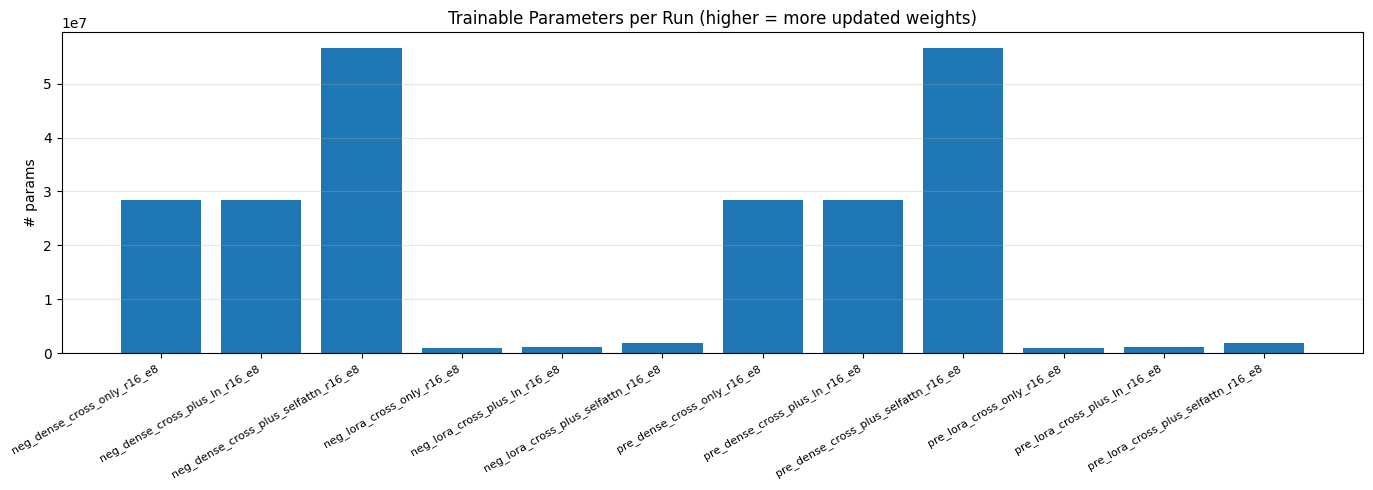

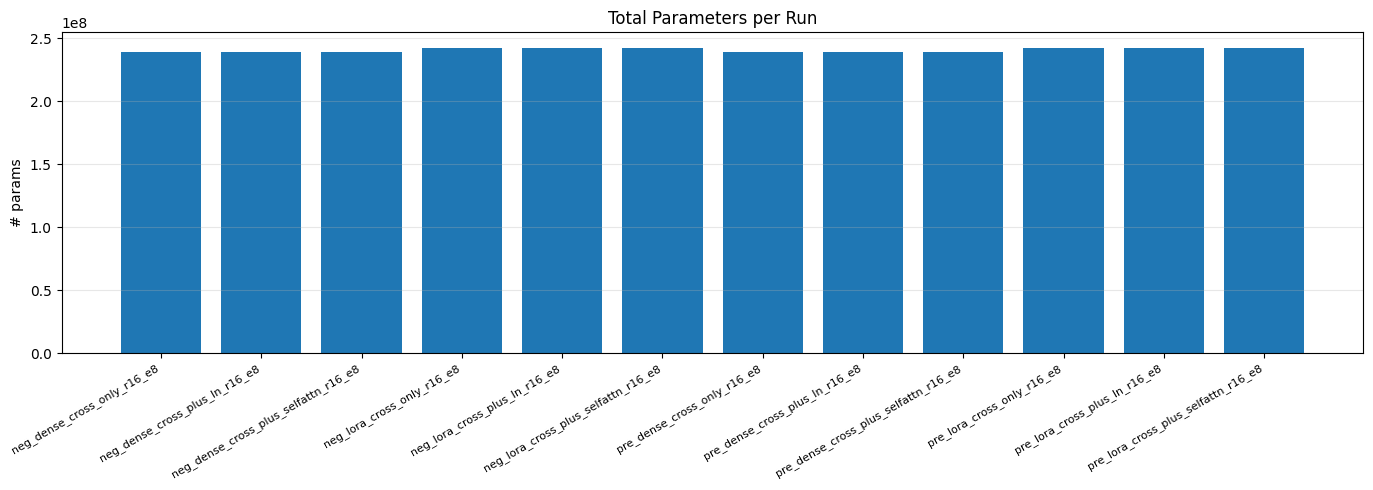

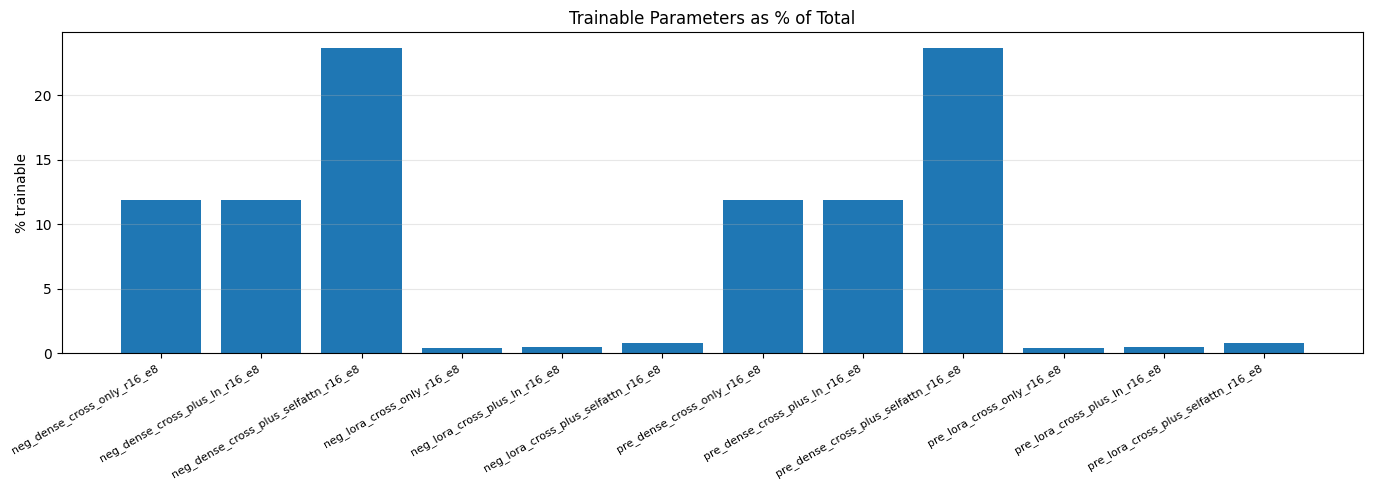

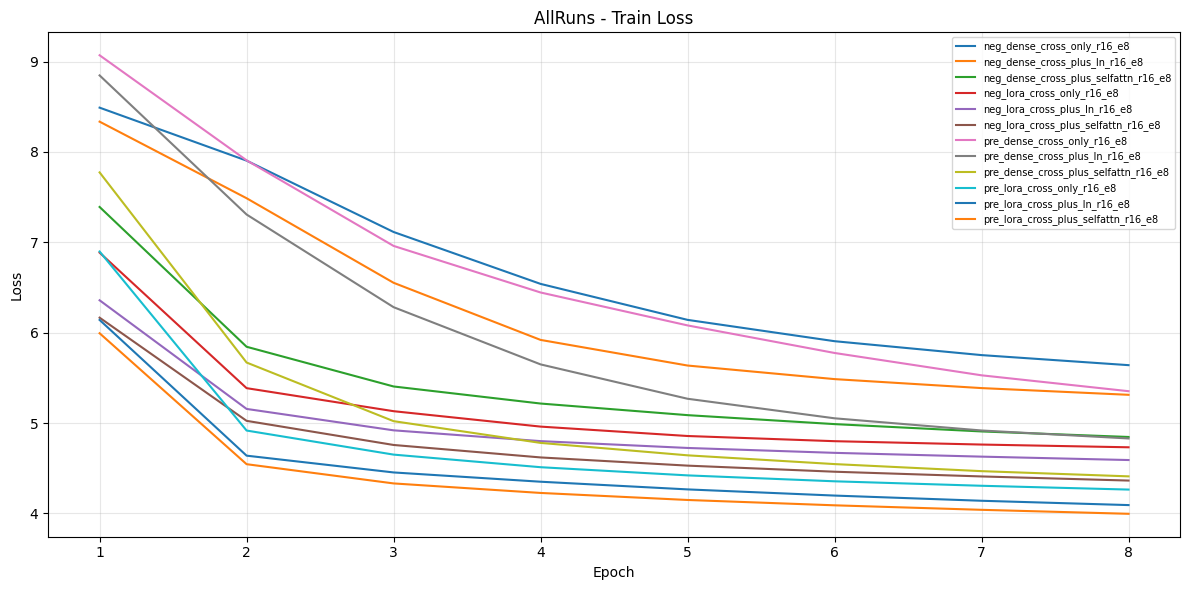

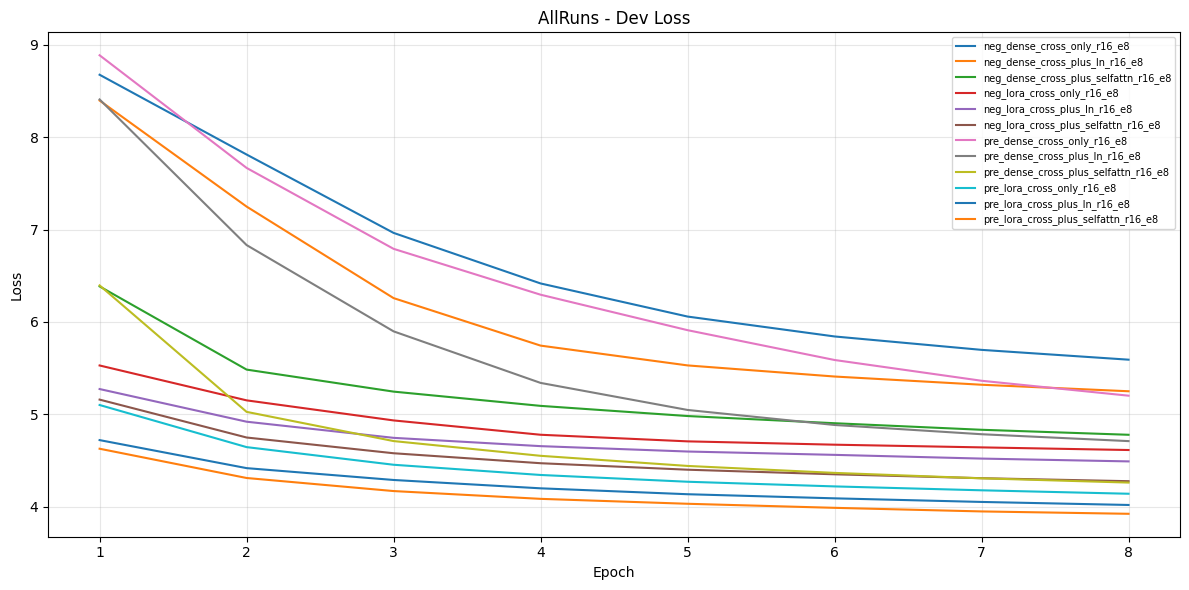

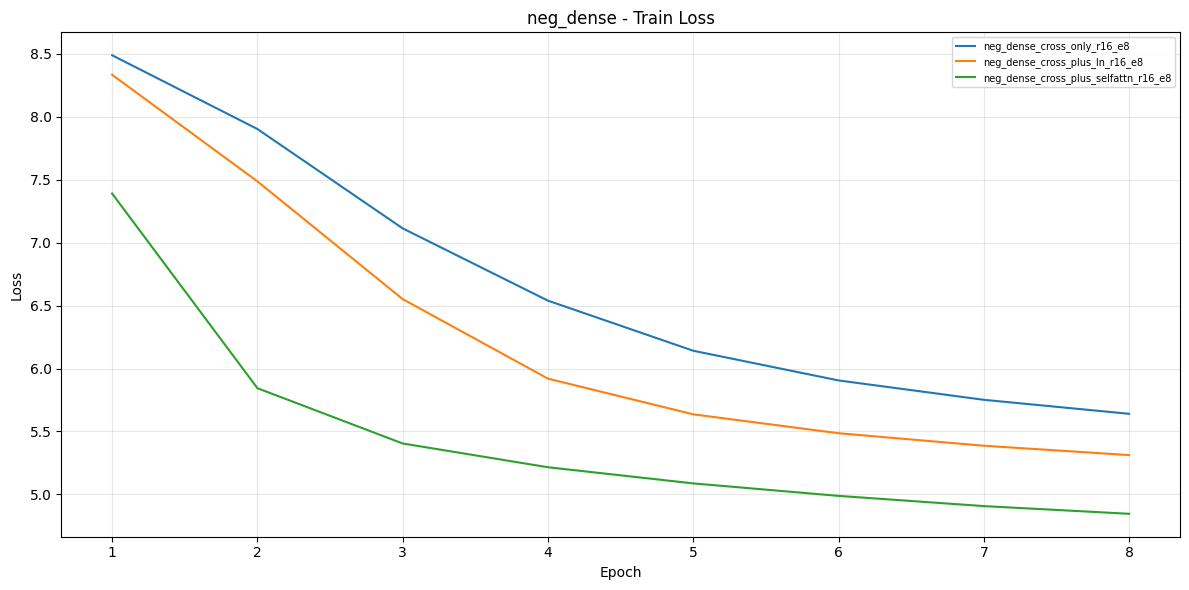

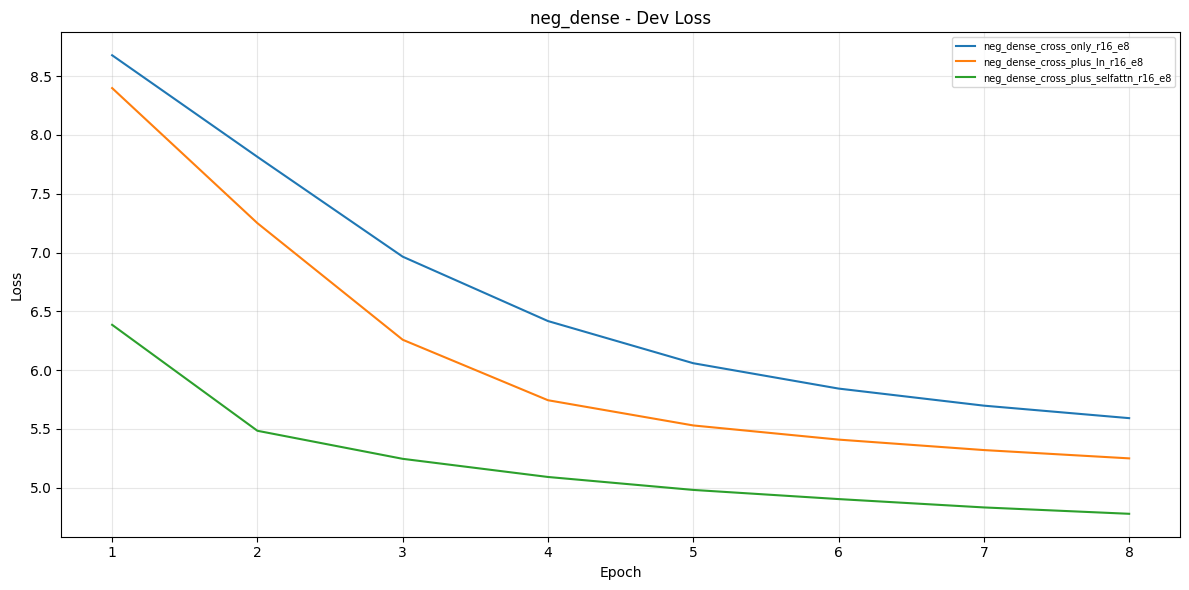

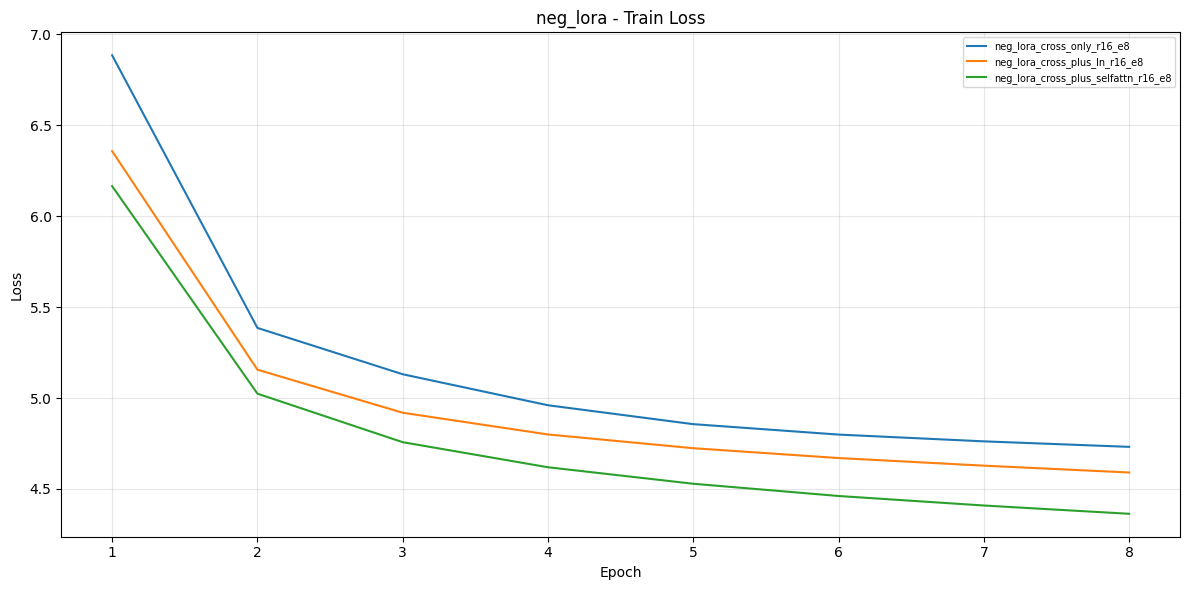

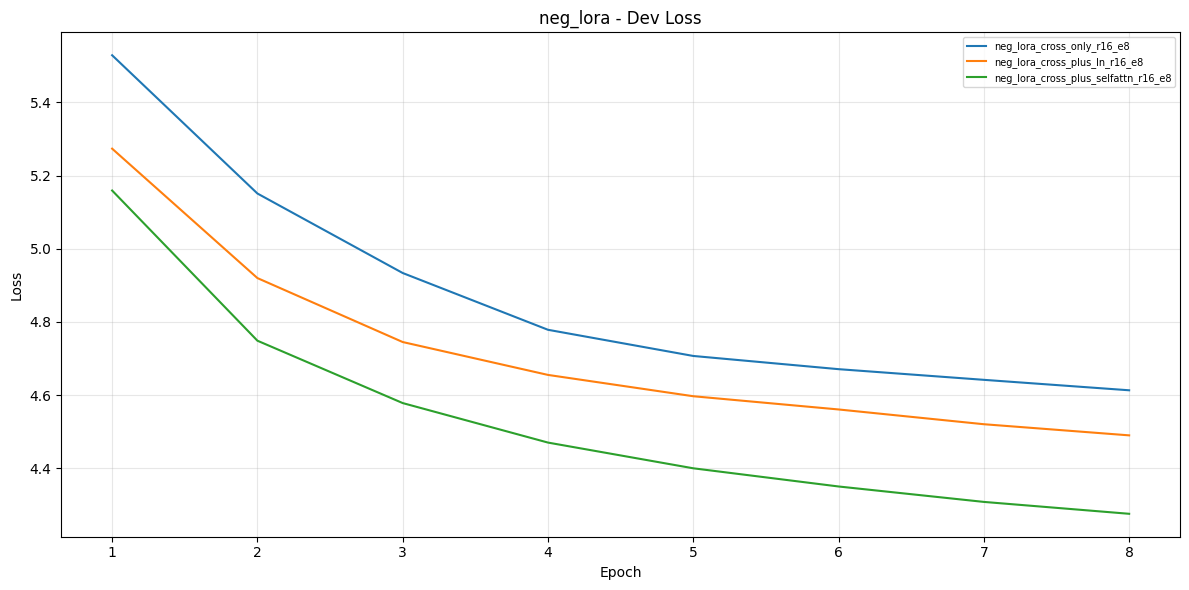

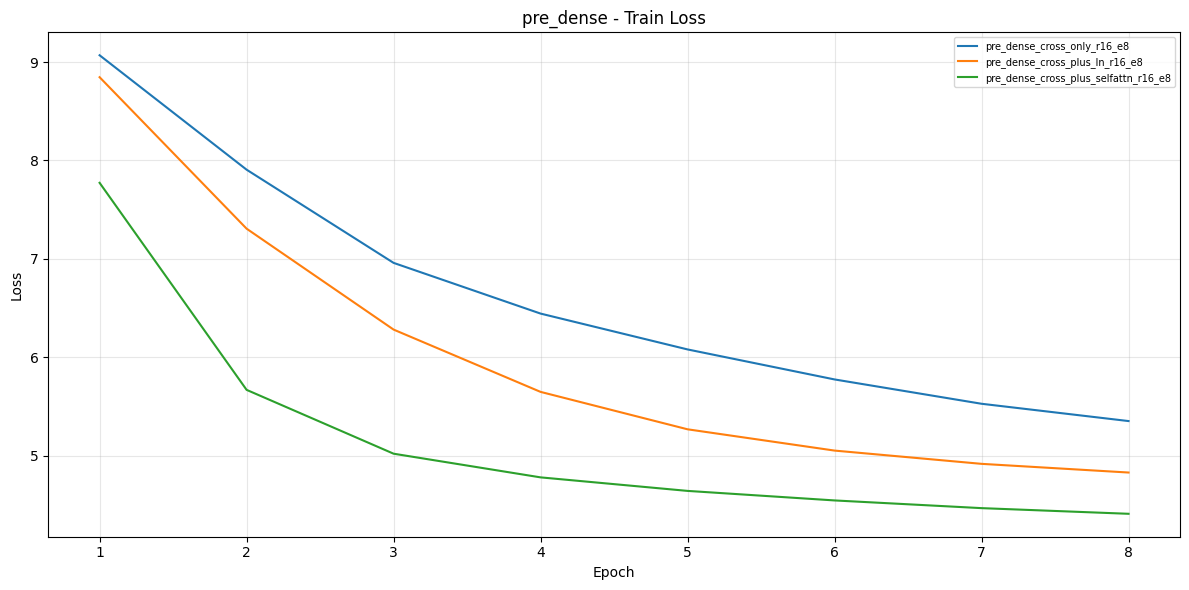

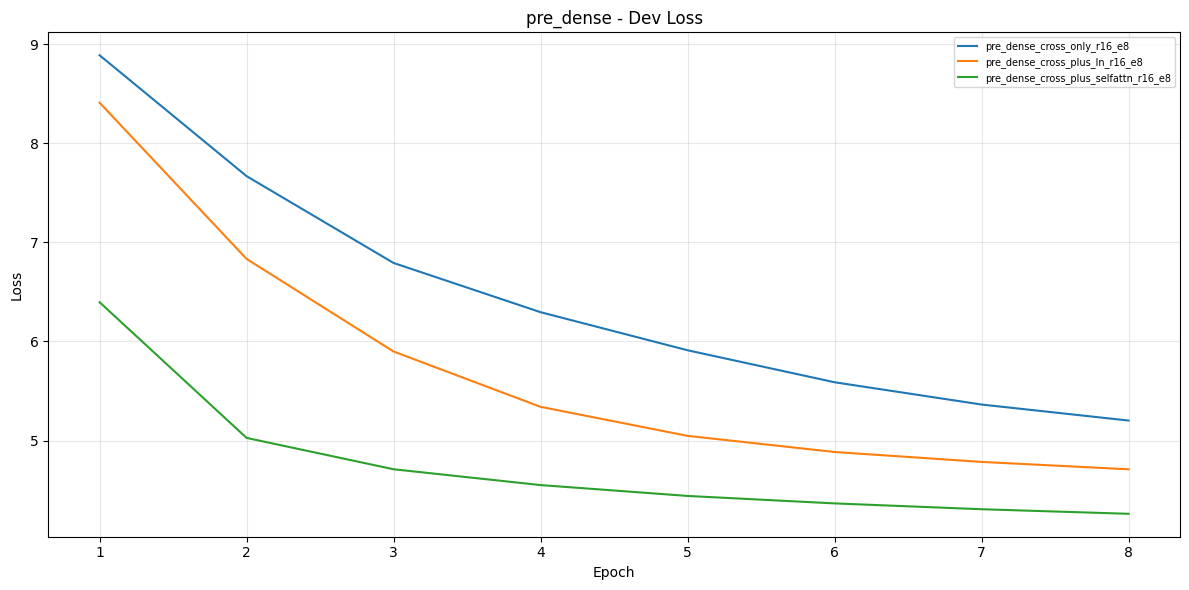

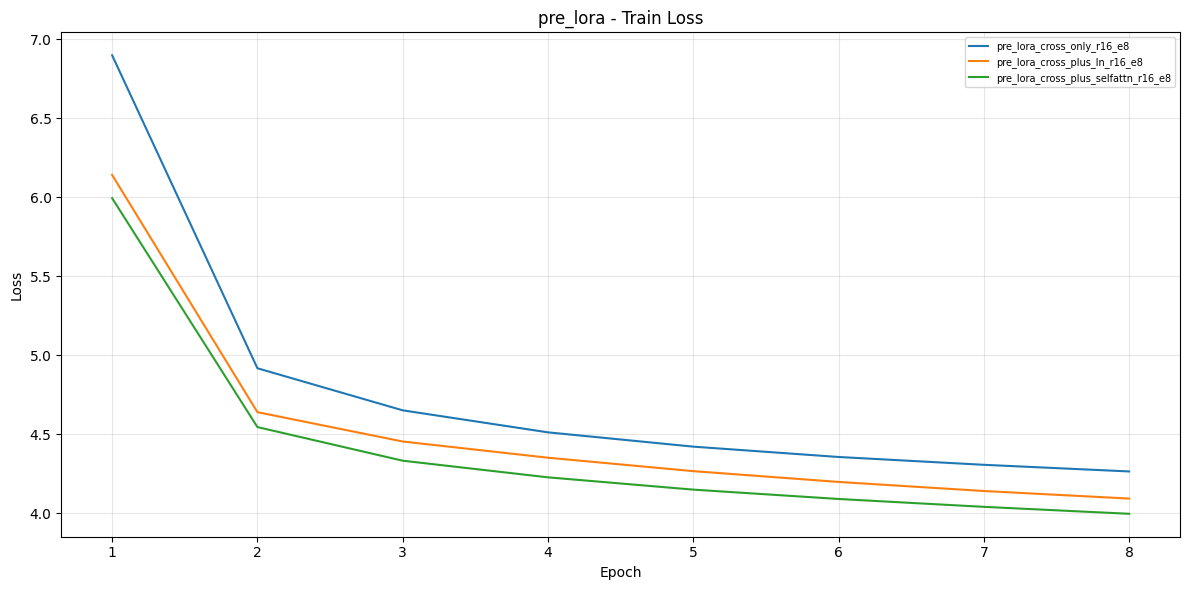

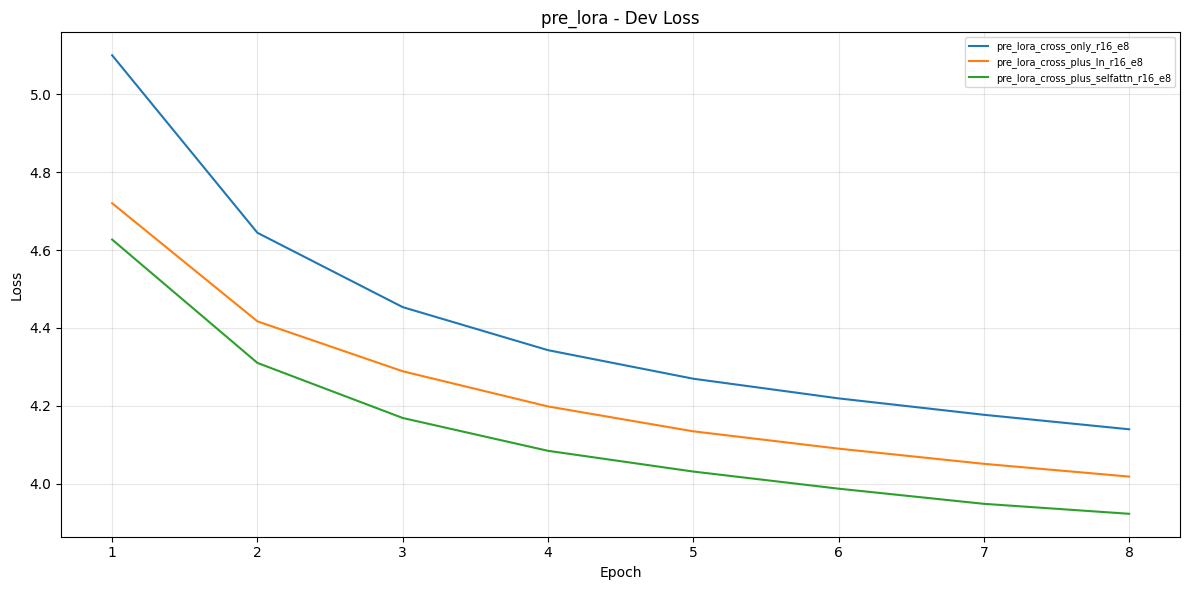

Eval neg_dense_cross_only_r16_e8: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s]


{'testlen': 19898, 'reflen': 15740, 'guess': [19898, 18898, 17898, 16898], 'correct': [3198, 138, 6, 1]}
ratio: 1.264167725539945

neg_dense_cross_only_r16_e8: test_loss=5.4985
  1. 3385593926_d3e9c21170.jpg: is a a . . . . . . . . . . . . . . . . .
  2. 2677656448_6b7e7702af.jpg: is a a . . . . . . . . . . . . . . . . .
  3. 311146855_0b65fdb169.jpg: of a a a . . . . . . . . . . . . . . . .
  4. 1258913059_07c613f7ff.jpg: of a a a . . . . . . . . . . . . . . . .
  5. 241347760_d44c8d3a01.jpg: . . . . . . . . . . . . . . . . . . . .


Eval neg_dense_cross_plus_ln_r16_e8: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


{'testlen': 19985, 'reflen': 15753, 'guess': [19985, 18985, 17985, 16985], 'correct': [3822, 206, 9, 1]}
ratio: 1.268647241795133

neg_dense_cross_plus_ln_r16_e8: test_loss=5.1399
  1. 3385593926_d3e9c21170.jpg: and dog a a a . . . . . . . . . . . . . . .
  2. 2677656448_6b7e7702af.jpg: in black jumps a . . . . . . . . . . . . . . . .
  3. 311146855_0b65fdb169.jpg: in black and white holding a . . . . . . . . . . . . . .
  4. 1258913059_07c613f7ff.jpg: in black and white holding a . . . . . . . . . . . . . .
  5. 241347760_d44c8d3a01.jpg: in black jumps a . . . . . . . . . . . . . . . .


Eval neg_dense_cross_plus_selfattn_r16_e8: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]


{'testlen': 19625, 'reflen': 15697, 'guess': [19625, 18625, 17625, 16625], 'correct': [4135, 156, 3, 0]}
ratio: 1.2502388991526248

neg_dense_cross_plus_selfattn_r16_e8: test_loss=4.6609
  1. 3385593926_d3e9c21170.jpg: and dog through snow a . . . . . . . . . . . . . . .
  2. 2677656448_6b7e7702af.jpg: and dog together in pool a . . . . . . . . . . . . . .
  3. 311146855_0b65fdb169.jpg: A man a shirt a shirt a shirt a . . . . . . . . . .
  4. 1258913059_07c613f7ff.jpg: A man a shirt a shirt a shirt a shirt a . . . . . . . .
  5. 241347760_d44c8d3a01.jpg: and are playing a . . . . . . . . . . . . . . . .


Eval neg_lora_cross_only_r16_e8: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]


{'testlen': 19936, 'reflen': 15753, 'guess': [19936, 18936, 17936, 16936], 'correct': [4275, 147, 3, 0]}
ratio: 1.2655367231637615

neg_lora_cross_only_r16_e8: test_loss=4.4974
  1. 3385593926_d3e9c21170.jpg: dog a is a dog the . . . . . . . . . . . . . .
  2. 2677656448_6b7e7702af.jpg: and dog in water . . . . . . . . . . . . . . . .
  3. 311146855_0b65fdb169.jpg: is a man a and woman a . . . . . . . . . . . . .
  4. 1258913059_07c613f7ff.jpg: is a man a and woman a . . . . . . . . . . . . .
  5. 241347760_d44c8d3a01.jpg: player a is a . . . . . . . . . . . . . . . .


Eval neg_lora_cross_plus_ln_r16_e8: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]


{'testlen': 19856, 'reflen': 15724, 'guess': [19856, 18856, 17856, 16856], 'correct': [4366, 122, 1, 0]}
ratio: 1.262783006868401

neg_lora_cross_plus_ln_r16_e8: test_loss=4.3721
  1. 3385593926_d3e9c21170.jpg: dog through snow a in of . . . . . . . . . . . . . .
  2. 2677656448_6b7e7702af.jpg: dog swimming in pool a . . . . . . . . . . . . . . .
  3. 311146855_0b65fdb169.jpg: in black and white are in of . . . . . . . . . . . . .
  4. 1258913059_07c613f7ff.jpg: is in of room a . . . . . . . . . . . . . . .
  5. 241347760_d44c8d3a01.jpg: player a is a . . . . . . . . . . . . . . . .


Eval neg_lora_cross_plus_selfattn_r16_e8: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]


{'testlen': 19871, 'reflen': 15752, 'guess': [19871, 18871, 17871, 16871], 'correct': [5054, 139, 3, 0]}
ratio: 1.2614906043676193

neg_lora_cross_plus_selfattn_r16_e8: test_loss=4.1660
  1. 3385593926_d3e9c21170.jpg: dog through snow a . . . . . . . . . . . . . . . .
  2. 2677656448_6b7e7702af.jpg: and dog a in pool a in pool a . . . . . . in . . . .
  3. 311146855_0b65fdb169.jpg: in white white white white white white white white white white white white white white white white white white white
  4. 1258913059_07c613f7ff.jpg: is a man a and woman a sitting a on bench a in of . . . . . .
  5. 241347760_d44c8d3a01.jpg: player a in uniform a in uniform a . . . . . . . . . . . .


Eval pre_dense_cross_only_r16_e8: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]


{'testlen': 18598, 'reflen': 14998, 'guess': [18598, 17598, 16598, 15598], 'correct': [4112, 624, 124, 32]}
ratio: 1.2400320042671529

pre_dense_cross_only_r16_e8: test_loss=5.1366
  1. 3385593926_d3e9c21170.jpg: dog running a a in . . . . . . . . . . . . . . .
  2. 2677656448_6b7e7702af.jpg: dog playing a in a in swimming pool . . . . . . . . . . . .
  3. 311146855_0b65fdb169.jpg: a a a a a . . . . . . . . . . . . . . .
  4. 1258913059_07c613f7ff.jpg: a a a a a a a a a a a a a and a . . . . .
  5. 241347760_d44c8d3a01.jpg: a man wearing a uniform and wearing a uniform and wearing a uniform and wearing a uniform and wearing a


Eval pre_dense_cross_plus_ln_r16_e8: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]


{'testlen': 19539, 'reflen': 15559, 'guess': [19539, 18539, 17539, 16539], 'correct': [4858, 780, 100, 19]}
ratio: 1.2558005013174847

pre_dense_cross_plus_ln_r16_e8: test_loss=4.6532
  1. 3385593926_d3e9c21170.jpg: dog running a in snow . . . . . . . . . . . . . . .
  2. 2677656448_6b7e7702af.jpg: and dog playing a in swimming pool . . . . . . . . . . . . .
  3. 311146855_0b65fdb169.jpg: a man a a a a on a . . . . . . . . . . . .
  4. 1258913059_07c613f7ff.jpg: a woman sitting a a a a on a a . . . . . . . . . .
  5. 241347760_d44c8d3a01.jpg: in a uniform a a a a . . . . . . . . . . . . .


Eval pre_dense_cross_plus_selfattn_r16_e8: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]


{'testlen': 19909, 'reflen': 15748, 'guess': [19909, 18909, 17909, 16909], 'correct': [5289, 673, 64, 8]}
ratio: 1.2642240284479767

pre_dense_cross_plus_selfattn_r16_e8: test_loss=4.2002
  1. 3385593926_d3e9c21170.jpg: and dog running the . . . . . . . . . . . . . . . .
  2. 2677656448_6b7e7702af.jpg: and dog playing in pool the . . . . . . . . . . . . . .
  3. 311146855_0b65fdb169.jpg: in shorts a man a shirt a shirt a . . . . . . . . . . .
  4. 1258913059_07c613f7ff.jpg: a woman a sitting a on a in front a . . . . . . . . . .
  5. 241347760_d44c8d3a01.jpg: in black and white playing football a . . . . . . . . . . . . .


Eval pre_lora_cross_only_r16_e8: 100%|██████████| 32/32 [00:24<00:00,  1.28it/s]


{'testlen': 19864, 'reflen': 15743, 'guess': [19864, 18864, 17864, 16864], 'correct': [6036, 397, 24, 0]}
ratio: 1.2617671345994244

pre_lora_cross_only_r16_e8: test_loss=4.0599
  1. 3385593926_d3e9c21170.jpg: and dog running the . . . . . the . . . . . . . . . .
  2. 2677656448_6b7e7702af.jpg: playing a . . . . . . . . . in pool a . . . . . .
  3. 311146855_0b65fdb169.jpg: with man a shirt a shirt a shirt a shirt a shirt a and man a . on street .
  4. 1258913059_07c613f7ff.jpg: sits a with woman a and sitting a . in of . . . . . . . . .
  5. 241347760_d44c8d3a01.jpg: wearing red and white is a . . . . . . . . . . . . . .


Eval pre_lora_cross_plus_ln_r16_e8: 100%|██████████| 32/32 [00:24<00:00,  1.32it/s]


{'testlen': 15824, 'reflen': 13843, 'guess': [15824, 14824, 13824, 12824], 'correct': [5941, 1168, 231, 58]}
ratio: 1.1431048183196457

pre_lora_cross_plus_ln_r16_e8: test_loss=4.9358
  1. 3385593926_d3e9c21170.jpg: dog running a in field a dog on leash behind a fence a fence a dog on snow covered ground
  2. 2677656448_6b7e7702af.jpg: playing a pool with a dog on the inside of the swimming pool
  3. 311146855_0b65fdb169.jpg: boy a shirt a shirt a shirt a shirt on and a man a shirt a shirt a shirt on
  4. 1258913059_07c613f7ff.jpg: girl sitting a chair outside a restaurant looking at umbrella on table outside a building
  5. 241347760_d44c8d3a01.jpg: player wearing red and white playing a game of football with crowd watching behind him


Eval pre_lora_cross_plus_selfattn_r16_e8: 100%|██████████| 32/32 [00:24<00:00,  1.30it/s]


{'testlen': 19909, 'reflen': 15746, 'guess': [19909, 18909, 17910, 16911], 'correct': [4825, 251, 10, 0]}
ratio: 1.264384605614044

pre_lora_cross_plus_selfattn_r16_e8: test_loss=3.8312
  1. 3385593926_d3e9c21170.jpg: and dog playing the in . . . . . . . . . . . . . . .
  2. 2677656448_6b7e7702af.jpg: and dog swimming a . . . . . . . . . . . . . . . .
  3. 311146855_0b65fdb169.jpg: with man a shirt a shirt a shirt a shirt a shirt a shirt a shirt a shirt a shirt
  4. 1258913059_07c613f7ff.jpg: sits a outside with umbrella the outside a . . . . . . . . . . . .
  5. 241347760_d44c8d3a01.jpg: player red white white white white white white white white white white black black black black black black black black

Run                                        BLEU-1   BLEU-2   BLEU-3   BLEU-4   METEOR  ROUGE-L    CIDEr     Loss
--------------------------------------------------------------------------------------------------------------------------------------------
neg_dense_cross_only_r16_e8   

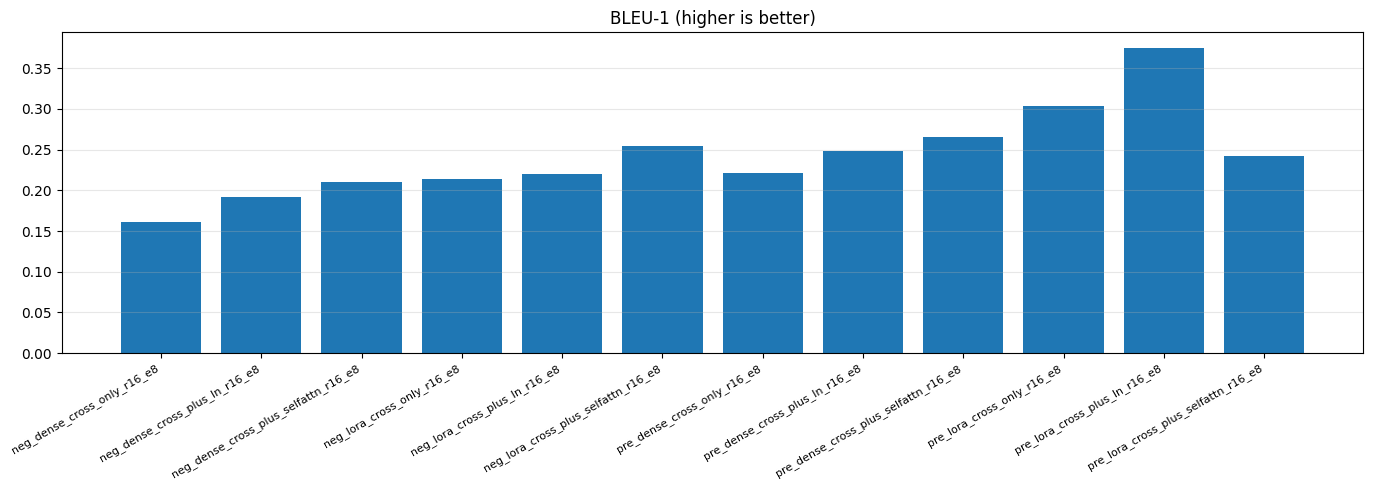

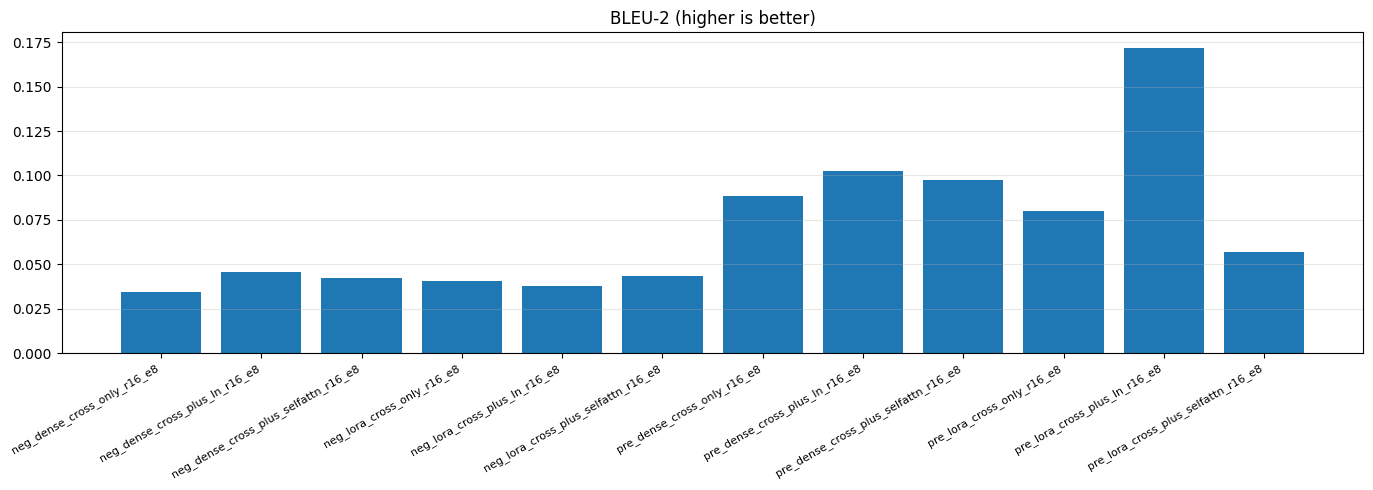

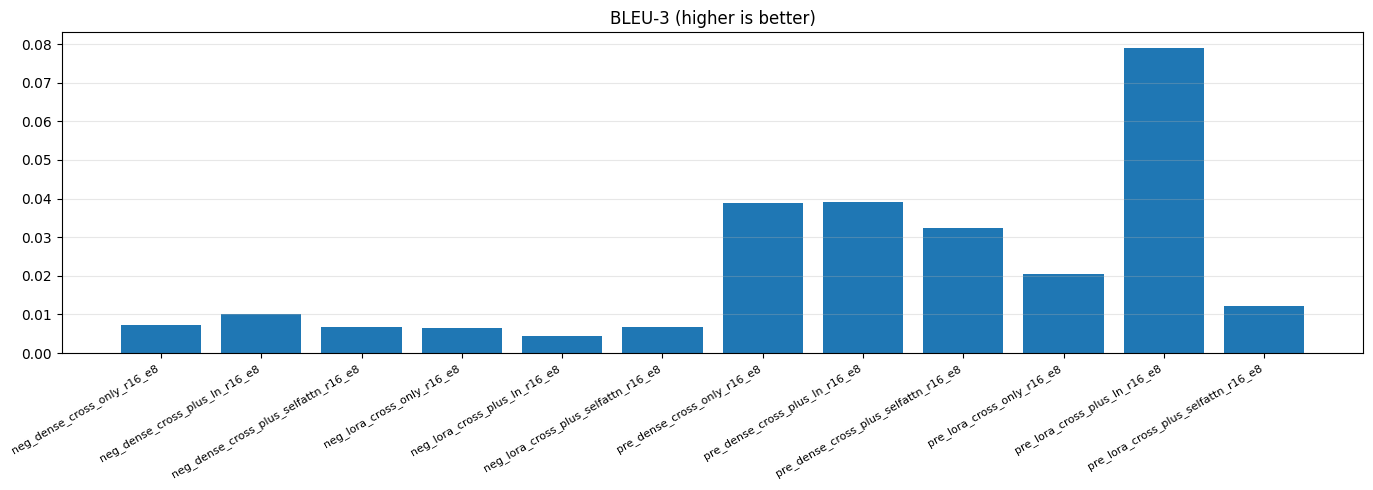

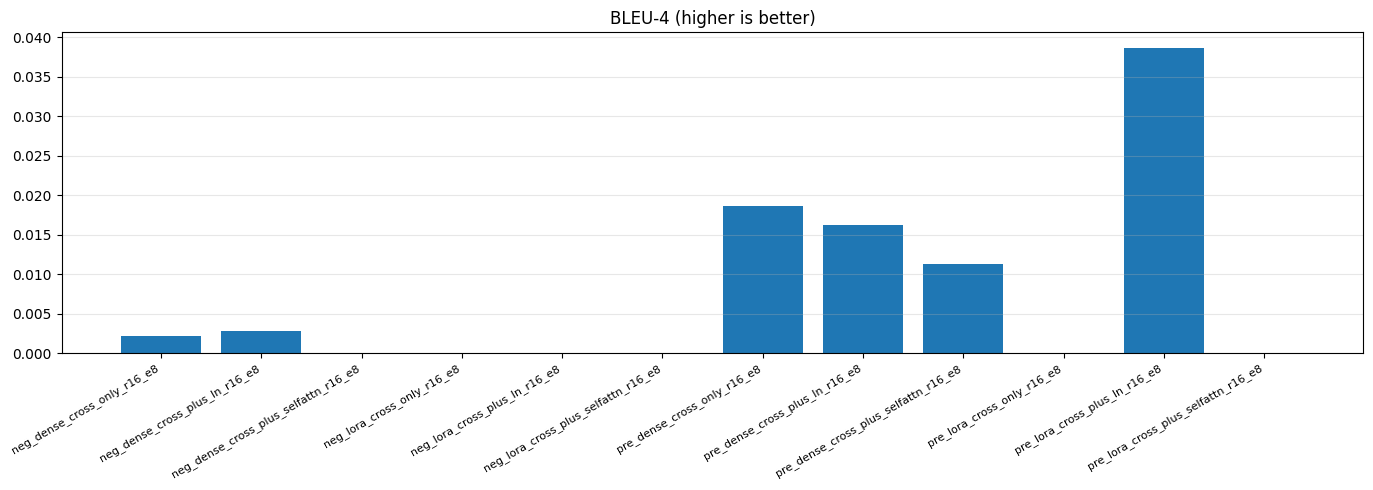

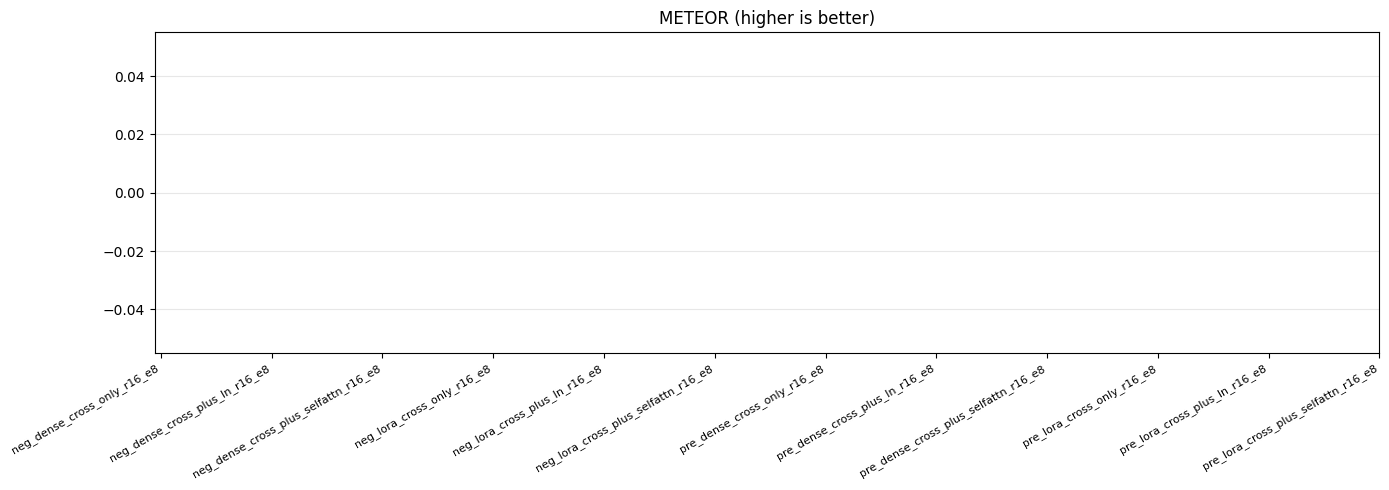

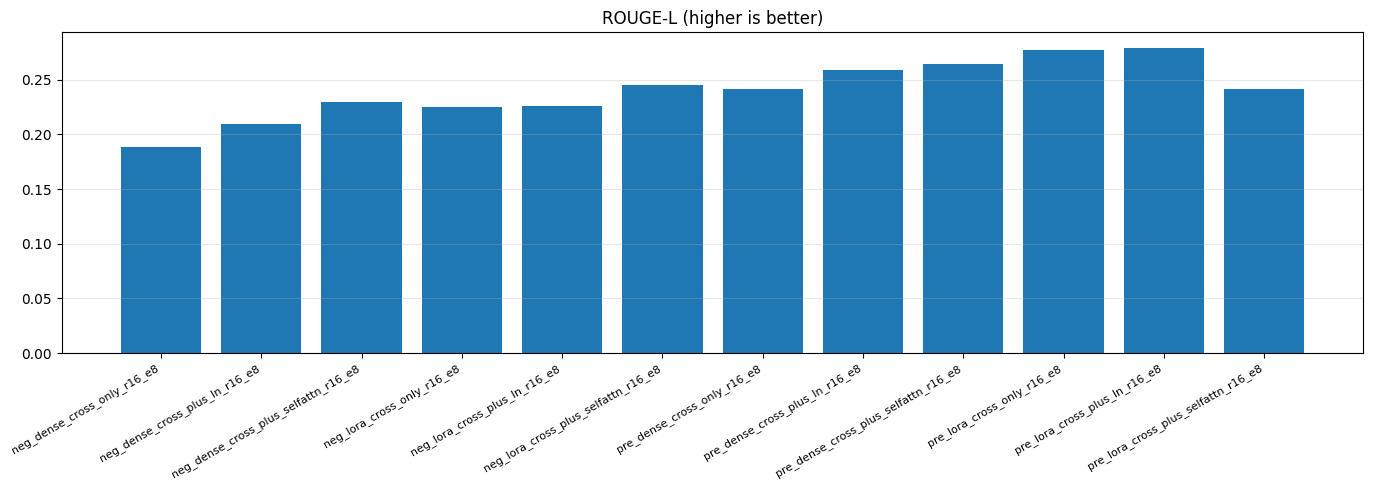

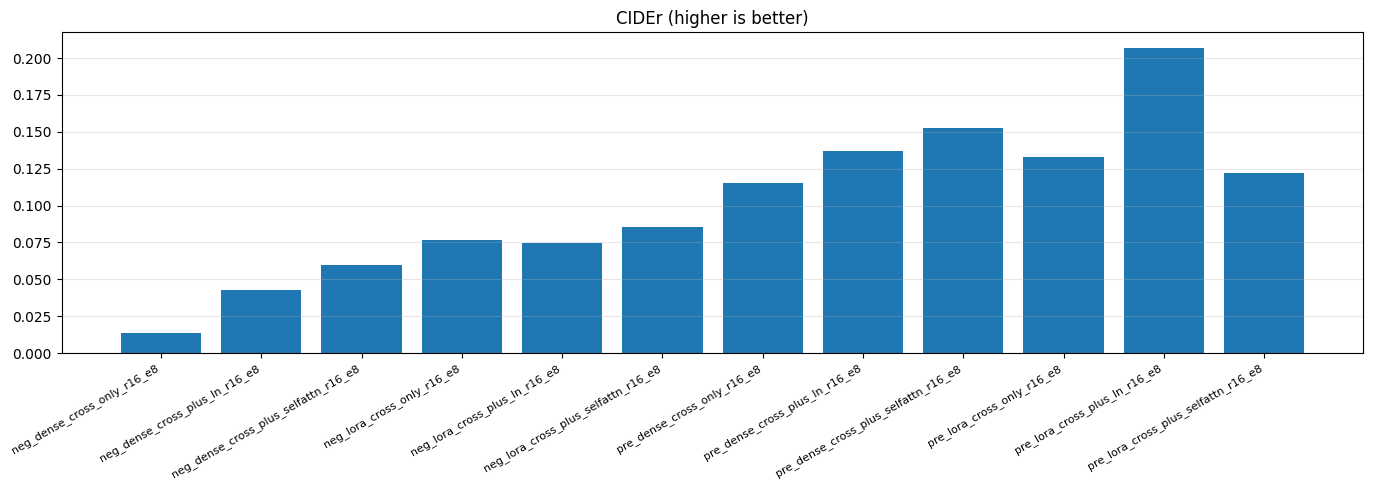

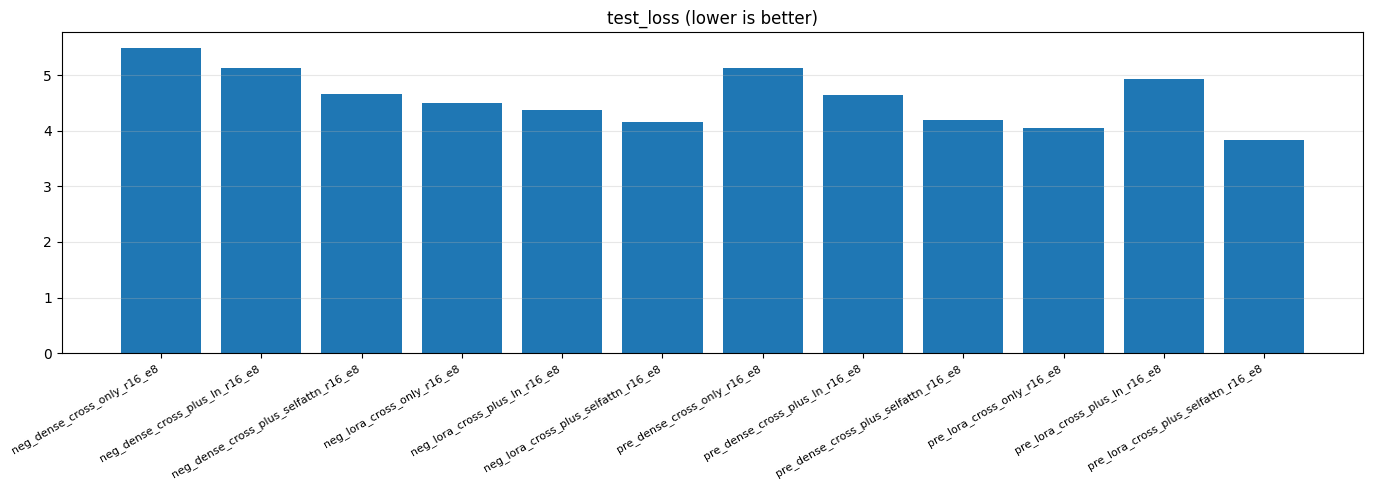


Done. Saved eval outputs to: ./ablations_out_8_16/eval_outputs
COCO metrics available: True


In [ ]:
# =========================
# ONE CELL: Loss curves + Metrics for EACH ablation (dense + lora)
#   cfg.OUT_DIR/<run_name>/
#       train_history.json
#       (either) pytorch_model.bin/config.json...  OR (for "pre"+"lora") decoder_lora/ + lora_model_info.json
#       tokenizer files
# Also assumes Flickr8k test_data.pickle exists in cfg.CAP_DIR.
# =========================

import os, json, math
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

from transformers import VisionEncoderDecoderModel, AutoTokenizer, ViTImageProcessor
from peft import PeftModel

_HAS_COCO = False
try:
    from pycocoevalcap.bleu.bleu import Bleu
    from pycocoevalcap.meteor.meteor import Meteor
    from pycocoevalcap.rouge.rouge import Rouge
    from pycocoevalcap.cider.cider import Cider
    _HAS_COCO = True
except Exception:
    _HAS_COCO = False


try:
    cfg
except NameError:
    class _Tmp: pass
    cfg = _Tmp()
    cfg.IMG_DIR = r'./Flickr8k_Data/Flicker8k_Dataset_resized'
    cfg.CAP_DIR = r'./Flicker8k_captions'
    cfg.OUT_DIR = r'./ablations_out_8_16'
    cfg.MAX_LEN = 48
    cfg.BATCH_SIZE = 32
    cfg.PRETRAINED_CAPTIONER = "nlpconnect/vit-gpt2-image-captioning"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
use_amp = (DEVICE == "cuda")
amp_dtype = torch.bfloat16 if DEVICE == "cuda" else torch.float32

EVAL_OUT_DIR = os.path.join(cfg.OUT_DIR, "eval_outputs")
os.makedirs(EVAL_OUT_DIR, exist_ok=True)


# -------------------------
# Data loading
# -------------------------
def load_pickle(path: str):
    import pickle
    with open(path, "rb") as f:
        return pickle.load(f)

test_data = load_pickle(os.path.join(cfg.CAP_DIR, "test_data.pickle"))
print(f"Loaded test images: {len(test_data)}")


# -------------------------
# Model/tokenizer helpers
# -------------------------
def ensure_pad(tokenizer):
    if tokenizer.pad_token is None and tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
    return tokenizer

def configure_for_captioning(model, tokenizer):
    model.config.pad_token_id = tokenizer.pad_token_id
    if model.config.eos_token_id is None and tokenizer.eos_token_id is not None:
        model.config.eos_token_id = tokenizer.eos_token_id
    if model.config.decoder_start_token_id is None:
        model.config.decoder_start_token_id = model.config.eos_token_id
    model.config.use_cache = False
    return model


def resolve_adapter_dir(dec_root: str) -> str:
    # If adapter_config is directly there, great.
    if os.path.isfile(os.path.join(dec_root, "adapter_config.json")):
        return dec_root

    # Otherwise, search one level down (e.g., decoder_lora/lora_all/adapter_config.json)
    if os.path.isdir(dec_root):
        for sub in os.listdir(dec_root):
            cand = os.path.join(dec_root, sub)
            if os.path.isfile(os.path.join(cand, "adapter_config.json")):
                return cand

    raise FileNotFoundError(f"No adapter_config.json found in {dec_root} (or its immediate subfolders).")


def load_run_model(run_dir: str):
    """
    Loads:
      - pre+lora format: run_dir/lora_model_info.json + decoder_lora/
      - otherwise: run_dir as regular HF VisionEncoderDecoderModel
    Returns (model, tokenizer, processor)
    """
    info_path = os.path.join(run_dir, "lora_model_info.json")

    # tokenizer
    tokenizer = AutoTokenizer.from_pretrained(run_dir)
    tokenizer = ensure_pad(tokenizer)

    if os.path.exists(info_path):
        with open(info_path, "r") as f:
            info = json.load(f)

        base_path = info["base_model_path"]
        model = VisionEncoderDecoderModel.from_pretrained(base_path)
        model = configure_for_captioning(model, tokenizer)

        # decoder LoRA
        dec_root = os.path.join(run_dir, "decoder_lora")
        dec_root = resolve_adapter_dir(dec_root)
        model.decoder = PeftModel.from_pretrained(model.decoder, dec_root)

        # processor: match captioner base
        processor = ViTImageProcessor.from_pretrained(base_path)
    else:
        model = VisionEncoderDecoderModel.from_pretrained(run_dir)
        model = configure_for_captioning(model, tokenizer)

        # pick processor based on the run type if local processor isn't present
        try:
            processor = ViTImageProcessor.from_pretrained(run_dir)
        except Exception:
            # read base_kind from train_history.json to choose correct processor
            hist_path = os.path.join(run_dir, "train_history.json")
            base_kind = None
            if os.path.exists(hist_path):
                with open(hist_path, "r") as f:
                    base_kind = json.load(f).get("base_kind", None)

            if base_kind == "pre":
                processor = ViTImageProcessor.from_pretrained(cfg.PRETRAINED_CAPTIONER)
            else:
                processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")


    model.to(DEVICE).eval()
    return model, tokenizer, processor


# -------------------------
# Dataset for evaluation (loss uses ONE ref caption; metrics use ALL refs)
# -------------------------
class Flickr8kTestDataset(Dataset):
    def __init__(self, test_data: dict, tokenizer, processor, img_dir: str, max_len: int):
        self.tokenizer = tokenizer
        self.processor = processor
        self.img_dir = img_dir
        self.max_len = max_len
        self.items = [(fn, caps[0]) for fn, caps in test_data.items()]  # 1 caption for loss alignment

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        fn, cap = self.items[idx]
        img = Image.open(os.path.join(self.img_dir, fn)).convert("RGB")
        pixel_values = self.processor(img, return_tensors="pt").pixel_values.squeeze(0)

        cap = cap.strip()
        if self.tokenizer.eos_token is not None and not cap.endswith(self.tokenizer.eos_token):
            cap = cap + self.tokenizer.eos_token

        tok = self.tokenizer(
            cap, padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt"
        )
        input_ids = tok.input_ids.squeeze(0)
        attention_mask = tok.attention_mask.squeeze(0)
        return {"pixel_values": pixel_values, "input_ids": input_ids, "attention_mask": attention_mask, "filename": fn}

def to_teacher_forcing(batch, tokenizer):
    ids = batch["input_ids"].to(DEVICE, non_blocking=True)
    am  = batch["attention_mask"].to(DEVICE, non_blocking=True)
    pv  = batch["pixel_values"].to(DEVICE, non_blocking=True)

    dec_in   = ids[:, :-1].contiguous()
    dec_mask = am[:, :-1].contiguous()
    labels   = ids[:,  1:].contiguous().clone()
    labels[labels == tokenizer.pad_token_id] = -100
    return pv, dec_in, dec_mask, labels


# -------------------------
# Metrics
# -------------------------
def compute_coco_metrics(preds: dict, refs: dict):
    gts = refs
    res = {k: [preds[k]] for k in preds.keys()}
    scorers = [
        (Bleu(4), ["BLEU-1","BLEU-2","BLEU-3","BLEU-4"]),
        # (Meteor(), "METEOR"),   # METEOR calculations causing the model to freeze temporarily disabling them
        (Rouge(), "ROUGE-L"),
        (Cider(), "CIDEr"),
    ]
    out = {}
    for scorer, method in scorers:
        try:
            score, _ = scorer.compute_score(gts, res)
            if isinstance(method, list):
                for m, s in zip(method, score):
                    out[m] = float(s)
            else:
                out[method] = float(score)
        except Exception as e:
            if isinstance(method, list):
                for m in method: out[m] = float("nan")
            else:
                out[method] = float("nan")
            print(f"⚠️ Metric {method} failed: {e}")
    return out



# -------------------------
# Evaluate a run dir -> test loss + metrics + sample captions
# -------------------------
@torch.no_grad()
def evaluate_run(run_dir: str, display_name: str, *, batch_size=None, max_new_tokens=20, num_beams=4):
    model, tokenizer, processor = load_run_model(run_dir)
    ds = Flickr8kTestDataset(test_data, tokenizer, processor, cfg.IMG_DIR, cfg.MAX_LEN)
    dl = DataLoader(ds, batch_size=(batch_size or cfg.BATCH_SIZE), shuffle=False,
                    num_workers=min(8, os.cpu_count() or 4),
                    pin_memory=(DEVICE=="cuda"))

    total_loss = 0.0
    preds = {}

    for batch in tqdm(dl, desc=f"Eval {display_name}"):
        pv, dec_in, dec_mask, labels = to_teacher_forcing(batch, tokenizer)

        with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=use_amp):
            out = model(pixel_values=pv, decoder_input_ids=dec_in, decoder_attention_mask=dec_mask, labels=labels)
        total_loss += float(out.loss.item())

        gen_ids = model.generate(
            pixel_values=pv,
            max_new_tokens=max_new_tokens,
            num_beams=num_beams,
            do_sample=False,  # deterministic for metrics
            early_stopping=True,
            decoder_start_token_id=model.config.decoder_start_token_id,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=model.config.eos_token_id,
        )
        texts = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)

        for fn, txt in zip(batch["filename"], texts):
            preds[fn] = txt.strip()

    avg_loss = total_loss / max(1, len(dl))

    metrics = {}
    if _HAS_COCO:
        metrics = compute_coco_metrics(preds, test_data)
    else:
        print("⚠️ pycocoevalcap not installed; skipping BLEU/METEOR/ROUGE/CIDEr. (pip install pycocoevalcap)")
        metrics = {"BLEU-1": np.nan, "BLEU-2": np.nan, "BLEU-3": np.nan, "BLEU-4": np.nan,
                   "METEOR": np.nan, "ROUGE-L": np.nan, "CIDEr": np.nan}

    # show examples
    print(f"\n{display_name}: test_loss={avg_loss:.4f}")
    for i, (fn, cap) in enumerate(list(preds.items())[:5], 1):
        print(f"  {i}. {fn}: {cap}")

    return {
        "experiment_name": display_name,
        "run_dir": run_dir,
        "test_loss": float(avg_loss),
        "metrics": metrics,
        "decoding": {"max_new_tokens": max_new_tokens, "num_beams": num_beams, "do_sample": False},
    }


# -------------------------
# Collect run dirs automatically from cfg.OUT_DIR
# -------------------------
def list_runs(out_dir: str):
    runs = []
    for sub in sorted(os.listdir(out_dir)):
        run_dir = os.path.join(out_dir, sub)
        if not os.path.isdir(run_dir):
            continue
        if os.path.exists(os.path.join(run_dir, "train_history.json")):
            runs.append((sub, run_dir))
    return runs

runs = list_runs(cfg.OUT_DIR)
print(f"Found {len(runs)} run folders with train_history.json")


# -------------------------
# Load histories + plot curves (per base_kind or per method)
# -------------------------
def load_histories(runs):
    h = {}
    for run_name, run_dir in runs:
        with open(os.path.join(run_dir, "train_history.json"), "r") as f:
            hist = json.load(f)
        h[run_name] = hist
    return h

histories = load_histories(runs)


def plot_param_bars(histories: dict, out_dir: str, show=True):
    os.makedirs(out_dir, exist_ok=True)

    names = list(histories.keys())
    total = np.array([histories[n].get("total_params", np.nan) for n in names], dtype=float)
    trainable = np.array([histories[n].get("trainable_params", np.nan) for n in names], dtype=float)

    # --- Trainable params bar ---
    plt.figure(figsize=(14, 5))
    x = np.arange(len(names))
    plt.bar(x, trainable)
    plt.xticks(x, names, rotation=30, ha="right", fontsize=8)
    plt.title("Trainable Parameters per Run (higher = more updated weights)")
    plt.ylabel("# params")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "bar_trainable_params.png"), dpi=150, bbox_inches="tight")
    if show: plt.show()
    plt.close()

    # --- Total params bar (usually same within a base model, but plot anyway) ---
    plt.figure(figsize=(14, 5))
    plt.bar(x, total)
    plt.xticks(x, names, rotation=30, ha="right", fontsize=8)
    plt.title("Total Parameters per Run")
    plt.ylabel("# params")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "bar_total_params.png"), dpi=150, bbox_inches="tight")
    if show: plt.show()
    plt.close()

    # --- Trainable fraction (%) ---
    frac = (trainable / total) * 100.0
    plt.figure(figsize=(14, 5))
    plt.bar(x, frac)
    plt.xticks(x, names, rotation=30, ha="right", fontsize=8)
    plt.title("Trainable Parameters as % of Total")
    plt.ylabel("% trainable")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "bar_trainable_fraction_pct.png"), dpi=150, bbox_inches="tight")
    if show: plt.show()
    plt.close()

# call it
plot_param_bars(histories, out_dir=os.path.join(EVAL_OUT_DIR, "param_plots"), show=True)


def plot_loss_curves(histories: dict, *, title_prefix="All", out_dir=None, show=True):
    def get_key(h, a, b):
        return h[a] if a in h else (h[b] if b in h else None)

    # Train
    plt.figure(figsize=(12, 6))
    for name, h in histories.items():
        tr = get_key(h, "train_loss", "train_losses")
        if tr is None: continue
        plt.plot(range(1, len(tr)+1), tr, label=name)
    plt.title(f"{title_prefix} - Train Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True, alpha=0.3)
    plt.legend(fontsize=7)
    plt.tight_layout()
    if out_dir:
        os.makedirs(out_dir, exist_ok=True)
        plt.savefig(os.path.join(out_dir, f"{title_prefix}_train_loss.png"), dpi=150, bbox_inches="tight")
    if show: plt.show()
    plt.close()

    # Dev
    plt.figure(figsize=(12, 6))
    for name, h in histories.items():
        dv = get_key(h, "dev_loss", "dev_losses")
        if dv is None: continue
        plt.plot(range(1, len(dv)+1), dv, label=name)
    plt.title(f"{title_prefix} - Dev Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True, alpha=0.3)
    plt.legend(fontsize=7)
    plt.tight_layout()
    if out_dir:
        plt.savefig(os.path.join(out_dir, f"{title_prefix}_dev_loss.png"), dpi=150, bbox_inches="tight")
    if show: plt.show()
    plt.close()

# Plot all
plot_loss_curves(histories, title_prefix="AllRuns", out_dir=os.path.join(EVAL_OUT_DIR, "loss_plots"))

def group_histories(histories, key_fields=("base_kind","method")):
    groups = {}
    for name, h in histories.items():
        k = tuple(h.get(f, "UNK") for f in key_fields)
        groups.setdefault(k, {})[name] = h
    return groups

groups = group_histories(histories)
for (bk, mth), g in groups.items():
    plot_loss_curves(g, title_prefix=f"{bk}_{mth}", out_dir=os.path.join(EVAL_OUT_DIR, "loss_plots"), show=True)


# -------------------------
# Evaluate metrics for each run + summary table + bar charts
# -------------------------
def fmt(x):
    if x is None: return "N/A"
    if isinstance(x, float) and (math.isnan(x) or math.isinf(x)): return "N/A"
    return f"{x:.4f}"

all_results = {}
for run_name, run_dir in runs:
    display = run_name
    r = evaluate_run(run_dir, display)
    all_results[display] = r

# Save JSON summary
with open(os.path.join(EVAL_OUT_DIR, "ALL_EVAL_RESULTS.json"), "w") as f:
    json.dump(all_results, f, indent=2)

# Print table
print("\n" + "="*140)
print(f"{'Run':<40} {'BLEU-1':>8} {'BLEU-2':>8} {'BLEU-3':>8} {'BLEU-4':>8} {'METEOR':>8} {'ROUGE-L':>8} {'CIDEr':>8} {'Loss':>8}")
print("-"*140)
for name, r in all_results.items():
    m = r.get("metrics", {})
    print(
        f"{name:<40} "
        f"{fmt(m.get('BLEU-1')):>8} {fmt(m.get('BLEU-2')):>8} {fmt(m.get('BLEU-3')):>8} {fmt(m.get('BLEU-4')):>8} "
        f"{fmt(m.get('METEOR')):>8} {fmt(m.get('ROUGE-L')):>8} {fmt(m.get('CIDEr')):>8} "
        f"{fmt(r.get('test_loss')):>8}"
    )
print("="*140)

# Bar plots for each metric
def plot_metric_bars(all_results: dict, out_dir: str, show=True):
    os.makedirs(out_dir, exist_ok=True)
    names = list(all_results.keys())
    metric_keys = ["BLEU-1","BLEU-2","BLEU-3","BLEU-4","METEOR","ROUGE-L","CIDEr","test_loss"]

    for mk in metric_keys:
        vals = []
        for n in names:
            r = all_results[n]
            if mk == "test_loss":
                vals.append(r.get("test_loss", np.nan))
            else:
                vals.append(r.get("metrics", {}).get(mk, np.nan))
        vals = np.array(vals, dtype=float)

        plt.figure(figsize=(14, 5))
        x = np.arange(len(names))
        plt.bar(x, vals)
        plt.xticks(x, names, rotation=30, ha="right", fontsize=8)
        plt.title(mk + (" (lower is better)" if mk=="test_loss" else " (higher is better)"))
        plt.grid(True, axis="y", alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"bar_{mk.replace('/','_')}.png"), dpi=150, bbox_inches="tight")
        if show: plt.show()
        plt.close()

plot_metric_bars(all_results, out_dir=os.path.join(EVAL_OUT_DIR, "metric_plots"), show=True)

print(f"\nDone. Saved eval outputs to: {EVAL_OUT_DIR}")
print("COCO metrics available:", _HAS_COCO)


# Comprehensive Model Evaluation and Analysis

## Understanding the Evaluation Framework

This section implements an evaluation pipeline to answer the core research question: "Which adaptation strategy works best, and why?"

### Evaluation Philosophy:

Critical evaluation considerations include:

1. Multiple Metrics Matter:
- Loss: Direct optimization target, shows training effectiveness
- BLEU: N-gram overlap with references (standard but limited)  
- METEOR: Accounts for synonyms and word order (more linguistically informed)
- ROUGE-L: Longest common subsequence (captures fluency)
- CIDEr: Consensus-based metric (correlates well with human judgment)

2. Deterministic Generation:
do_sample=False, num_beams=4 is used for reproducible results. In research, reproducibility takes precedence over slight performance gains from sampling.

3. Parameter Efficiency Analysis:
The key LoRA selling point is efficiency. The following are tracked:
- Total parameters (model size)  
- Trainable parameters (adaptation cost)
- Performance retention (adaptation quality)

### What is Being Evaluated:

Success Criteria:
- LoRA methods should achieve competitive metrics with dramatically fewer trainable parameters
- Pretrained base should significantly outperform negative control
- Cross-attention focus should outperform broader adaptations (efficiency hypothesis)

Key Plots:
1. Loss Curves: Training dynamics and convergence
2. Parameter Efficiency: Trainable params vs performance 
3. Metric Comparison: Head-to-head performance across all runs

### Expected Insights:

From the deep learning literature, the following is expected:
- Diminishing Returns: More parameters do not equal proportionally better performance
- Critical Components: Cross-attention should punch above its weight
- Pretraining Benefits: Clear gaps should be observed between 'pre' vs 'neg' baselines

## Step 1: Model Loading and Setup

The code below handles the complexity of loading different model formats:
- Standard models: Saved as complete HuggingFace checkpoints  
- LoRA models: Saved as base model + adapter weights (more storage efficient)

Key Engineering Insight: In research, more time is spent on data loading/model reconstruction than expected. Robust loading logic saves hours of debugging.

## Step 2: Evaluation Metrics - Technical Implementation

Critical Research Note: Choosing the right metrics is often more important than the model itself.

### Metric Implementation Details:

**BLEU (Bilingual Evaluation Understudy)**:
- Computes precision of n-grams (1,2,3,4) between generated and reference captions
- Includes brevity penalty
- Limitation: Does not understand semantics (penalizes valid synonyms)
- Usage rationale: Standard in the field, enables comparison with prior work

**ROUGE-L (Longest Common Subsequence)**: 
- Computes F1 score based on longest common subsequence
- Advantage over BLEU: More flexible about word order and sentence structure
- Research insight: Often correlates better with human judgment for longer sequences

**CIDEr (Consensus-based Image Description Evaluation)**:
- Uses TF-IDF weighting to emphasize informative word
- TF-IDF computed across entire test corpus to identify rare/important words
- Key advantage: Weighs words by how informative they are across the dataset
- Research gold standard: Best correlation with human evaluations (r≈0.9)

**METEOR (disabled due to computational overhead)**:
- Would compute alignment between hypothesis and reference using exact, stem, synonym, and paraphrase matches
- Includes penalty for word order differences
- Currently disabled to prevent evaluation freezing

### Technical Evaluation Pipeline:

**Deterministic Generation Setup**:
```python
gen_ids = model.generate(
    pixel_values=pixel_values,
    max_new_tokens=20,        # Sufficient for most captions
    num_beams=4,             # Beam search for quality
    do_sample=False,         # Deterministic (no sampling)
    early_stopping=True,     # Stop at EOS token
    decoder_start_token_id=model.config.decoder_start_token_id,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=model.config.eos_token_id,
)
```

**Loss Computation Strategy**:
- Uses teacher forcing: model sees ground truth previous tokens during training
- Test loss computed the same way for consistency with training objective
- Formula: CrossEntropyLoss(logits[:, :-1], labels[:, 1:]) with ignore_index=-100 for padding

**Metric Calculation Pipeline**:
```python
def compute_coco_metrics(predictions, references):
    # predictions: {image_id: generated_caption}
    # references: {image_id: [ref1, ref2, ref3, ref4, ref5]}
    
    # Convert to pycocoevalcap format
    gts = references  # Ground truth (multiple refs per image)
    res = {k: [predictions[k]] for k in predictions.keys()}  # Results (single pred per image)
    
    # Initialize scorers
    scorers = [
        (Bleu(4), ["BLEU-1","BLEU-2","BLEU-3","BLEU-4"]),
        (Rouge(), "ROUGE-L"),
        (Cider(), "CIDEr")
    ]
    
    # Compute scores with error handling
    for scorer, method_names in scorers:
        score, scores = scorer.compute_score(gts, res)
        # Handle both single scores and lists of scores
```

### Data Loading Technical Details:

**Model Loading Complexity**:
The evaluation handles two different model storage formats:
1. **Standard Models**: Complete HuggingFace checkpoint (config.json, pytorch_model.bin, tokenizer files)
2. **LoRA Models**: Base model + adapter weights stored separately

**LoRA Model Reconstruction**:
```python
# Load base model
model = VisionEncoderDecoderModel.from_pretrained(base_model_path)
# Load and attach LoRA adapter
model.decoder = PeftModel.from_pretrained(model.decoder, adapter_path)
```

**Processor/Tokenizer Matching**:
- Each model needs correct image processor (ViT preprocessing) and tokenizer (GPT-2 vocabulary)
- Code automatically detects model type from training history and matches appropriate components
- Handles edge cases like missing processor files by inferring from base model type

### Memory and Performance Optimizations:

**Mixed Precision Evaluation**:
- Uses same autocast settings as training for consistency
- bfloat16 precision reduces memory usage during generation
- Gradient computation disabled with @torch.no_grad() decorator

**Efficient Batching**:
- Test dataset uses single reference caption for loss computation (consistent with training)
- All 5 reference captions used for metric computation (comprehensive evaluation)
- Batch processing for both loss and generation to maximize GPU utilization

**Caching and I/O**:
- Results cached to JSON files to avoid recomputation
- Generated captions stored for qualitative analysis
- Plots automatically saved with high DPI for publication quality

This technical implementation ensures fair comparison across all experimental conditions while providing comprehensive evaluation of both training dynamics and final model performance.